# Toxicity Prediction Project
Final Project - Applied Case Studies of Machine Learning and Deep Learning in Key Areas 2

Bulloni Dyuman, Ippolito Manuel, Loddo Fabio - D3A

Import the required Python libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np
import random
from tabulate import tabulate
import itertools

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import os
from pathlib import Path
import datetime

# RDKit modules
import rdkit as rd
from rdkit import Chem
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole

# Deep Purpose modules
from DeepPurpose import *
from DeepPurpose import ProteinPred as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
from DeepPurpose import CompoundPred, dataset, utils

# DeepChem modules
import deepchem as dc
from deepchem.models import GraphConvModel

# ExMol modules
import exmol
import skunk

# Modeling
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Warnings
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import Dataset, DataLoader
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # use GPU if available

Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.
Could not import azure.core python package.


Settings

In [2]:
# Set seed value
SEED_VALUE = 124 #122 123 124, as used in MoleculeNet

# Set torch settings
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
#deeppurpose.utils.seed_everything(SEED_VALUE)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

# set-up rdkit drawing preferences
IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.drawMolsSameScale = False

Constants

In [3]:
# Number of bits for morgan fingerprints
MORGAN_BITS = 4096

# Number of radius for morgan fingerprints
MORGAN_RADIUS = 2

## Data Exploration

Import the data

In [4]:
# Define path to the Data folder
DATA_PATH: Path = Path(os.getcwd() + "/Data")
DATA_PATH

WindowsPath('c:/Users/manue/SUPSI/Sixth Semester User/Bio Grasso/Final project/toxicity_prediction/Data')

In [5]:
# Import the clintox dataset
# Clintox dataset contains clinical toxicology data
clintox = pd.read_csv(DATA_PATH / "clintox.csv")
clintox_task = ['CT_TOX']
clintox.head()

smiles  FDA_APPROVED  CT_TOX
0            *C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC             1       0
1  [C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...             1       0
2  [C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...             1       0
3  [H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...             1       0
4  [H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...             1       0

In vivo data (that in the reference papers come from the dataset RTECS by Biovia) are not available  publicly and require a fee or a subscription to be provided, so we will work on clinical and in vitro data for this project.

### Plot data

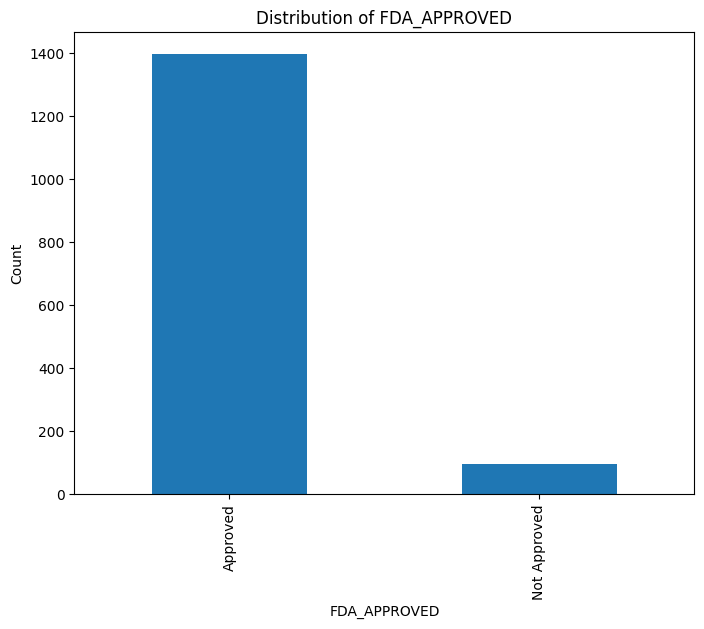

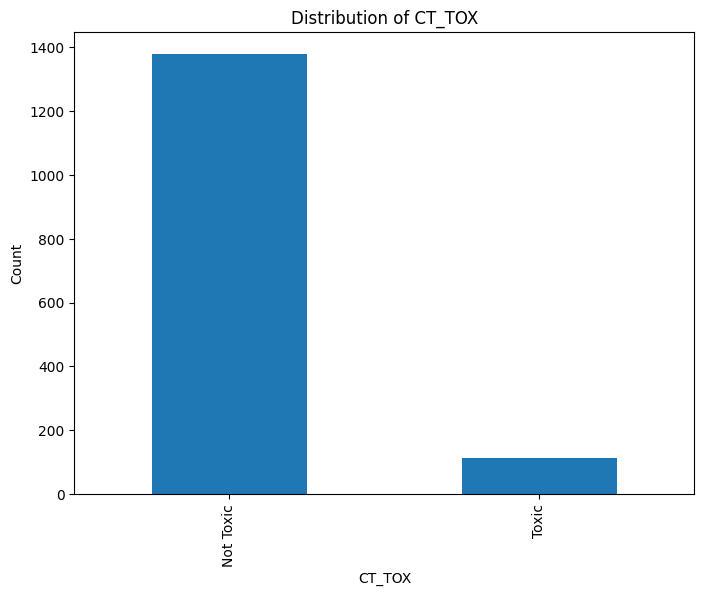

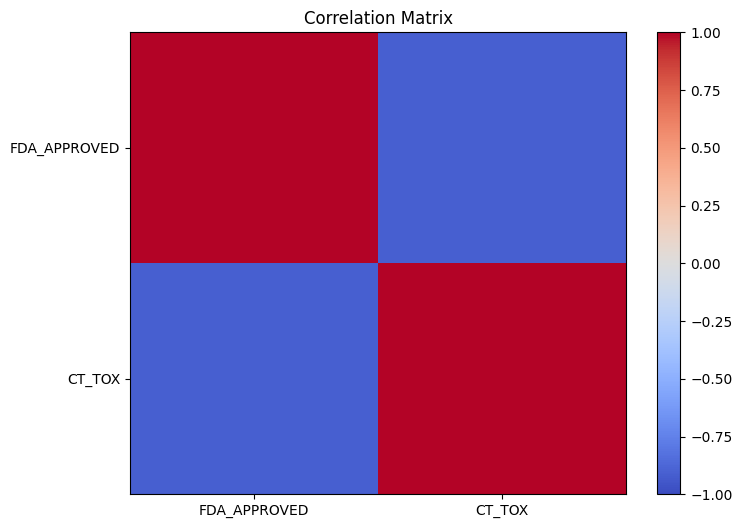

In [6]:
# Plot the distribution of FDA_APPROVED
plt.figure(figsize=(8, 6))
clintox['FDA_APPROVED'].value_counts().plot(kind='bar')
plt.title('Distribution of FDA_APPROVED')
plt.xlabel('FDA_APPROVED')
plt.ylabel('Count')
plt.xticks([0, 1], ['Approved', 'Not Approved'])
plt.show()

# Plot the distribution of CT_TOX
plt.figure(figsize=(8, 6))
clintox['CT_TOX'].value_counts().plot(kind='bar')
plt.title('Distribution of CT_TOX')
plt.xlabel('CT_TOX')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Toxic', 'Toxic'])
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
correlation_matrix = clintox[['FDA_APPROVED', 'CT_TOX']].corr()
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.colorbar()
plt.xticks([0, 1], ['FDA_APPROVED', 'CT_TOX'])
plt.yticks([0, 1], ['FDA_APPROVED', 'CT_TOX'])
plt.title('Correlation Matrix')
plt.show()

From the distributions of CT_TOX we can see that the dataset is unbalanced, as there are way more non toxic drugs than toxic drugs in it. The same for FDA_APPROVED, we have way more FDA approved drugs than non-FDA-approved drugs in the dataset.

It seems there is a net inverse correlation between FDA_APPROVED and CT_TOX. IT makes sense that FDA approved drugs are not toxic.

## Data Pre-Processing

### Process data

In [7]:
# Remove non valid rows (SMILES that cannot be converted to Canonical SMILES)
def remove_non_valid_rows(df: pd.DataFrame) -> pd.DataFrame:
    mol_list = []
    valid_rows = []
    for i, row in df.iterrows():
        mol = Chem.MolFromSmiles(row['smiles'])
        if mol is not None:
            mol_list.append(mol)
            valid_rows.append(row)

    df = pd.DataFrame(valid_rows)
    return df

In [8]:
# Clean the database, check for redundancy and remove duplicates

# Remove duplicated rows
print('Clintox dataset dimensions with duplicates:', clintox.shape)
clintox.drop_duplicates(inplace=True) # Drop duplicated rows
print('Clintox dataset dimensions without duplicates:', clintox.shape)

# Remove non valid rows (SMILES that cannot be converted to Canonical SMILES, null SMILES, duplicated SMILES)
clintox = remove_non_valid_rows(clintox) # remove rows with non valid SMILES
clintox.drop_duplicates(subset = ['smiles'], inplace=True) # Remove duplicated canonical SMILES
clintox.dropna(subset=['smiles'], inplace=True) # Remove null SMILES
print('Clintox dataset dimensions without non valid rows:', clintox.shape)
clintox.head(3)

Clintox dataset dimensions with duplicates: (1491, 3)
Clintox dataset dimensions without duplicates: (1484, 3)
Clintox dataset dimensions without non valid rows: (1478, 3)


smiles  FDA_APPROVED  CT_TOX
0            *C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC             1       0
1  [C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...             1       0
2  [C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...             1       0

In [9]:
# Check for null values
clintox.isna().sum()

smiles          0
FDA_APPROVED    0
CT_TOX          0
dtype: int64

### Train-test split
In the reference papers the split of data is provided, so we'll use their same splits in order to be able to compare our results with the state-of-the-art performances.

In [10]:
### Method borrowed from MoleculeNet for random splits of 0.8 / 0.1 / 0.1, train / test / valid 
# Returns index of random train, test, valid datasets in array of [train,test,valid]
def split(dataset,
            seed=None,
            frac_train=.8,
            frac_valid=.1,
            frac_test=.1,
            log_every_n=None):
    """
    Splits internal compounds randomly into train/validation/test.
    """
    np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.)
    if not seed is None:
        np.random.seed(seed)
    num_datapoints = len(dataset)
    train_cutoff = int(frac_train * num_datapoints)
    valid_cutoff = int((frac_train + frac_valid) * num_datapoints)
    shuffled = np.random.permutation(range(num_datapoints))
    return (shuffled[:train_cutoff], shuffled[train_cutoff:valid_cutoff],
            shuffled[valid_cutoff:])

In [11]:
# Split the Clintox dataset into train-test-validation sets with ratios 0.8/0.1/0.1
train_indices, test_indices, valid_indices = split(clintox, frac_train=0.8, frac_valid=0.1, frac_test=0.1)  # Use random seed from MoleculeNet

clintox_train = clintox.iloc[train_indices]
clintox_test = clintox.iloc[test_indices]
clintox_val = clintox.iloc[valid_indices]

clintox_data = [clintox_train, clintox_test, clintox_val]


In [12]:
# Check the number of samples in each set
print("Total number of samples, train: " + str(clintox_data[0].shape[0]))
print("Total number of samples, test: " + str(clintox_data[1].shape[0]))
print("Total number of samples, valid: " + str(clintox_data[2].shape[0]))
print("Total number of samples, train+test+valid: " + str(clintox_data[0].shape[0] + 
                                                           clintox_data[1].shape[0] + 
                                                           clintox_data[2].shape[0]))

Total number of samples, train: 1182
Total number of samples, test: 148
Total number of samples, valid: 148
Total number of samples, train+test+valid: 1478


## Modelling

#### Construct Morgan fingerprints

In [13]:
CLINTOX_TARGET = 'CT_TOX'

In [14]:
# Save a copy of train-test-val splits before adding informations
clintox_df = []
clintox_df.append(clintox_data[0].copy())
clintox_df.append(clintox_data[1].copy())
clintox_df.append(clintox_data[2].copy())

In [15]:
# Check clintox_data
clintox_data[0].head(3)

smiles  FDA_APPROVED  CT_TOX
755  CC(C)CN(C[C@H]([C@H](Cc1ccccc1)NC(=O)O[C@H]2CC...             1       0
96                             C1[C@H](C(=O)NO1)[NH3+]             1       0
671  CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...             0       1

In [16]:
# Construct morgan fingerprints 
for i in range(len(clintox_data)):
    clintox_data[i]['mol'] = [rd.Chem.MolFromSmiles(x) for x in clintox_data[i]['smiles']]

    bi = [{} for _ in range(len(clintox_data[i]))]
    clintox_data[i]['morgan'] = [AllChem.GetMorganFingerprintAsBitVect(clintox_data[i].iloc[j]['mol'], MORGAN_RADIUS, nBits = MORGAN_BITS, bitInfo=bi[j]) 
                         for j in range(len(clintox_data[i]))]
    clintox_data[i]['bitInfo'] = bi

In [17]:
# Check clintox_data
clintox_data[0].head(3)

smiles  FDA_APPROVED  CT_TOX   
755  CC(C)CN(C[C@H]([C@H](Cc1ccccc1)NC(=O)O[C@H]2CC...             1       0  \
96                             C1[C@H](C(=O)NO1)[NH3+]             1       0   
671  CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...             0       1   

                                                   mol   
755  <rdkit.Chem.rdchem.Mol object at 0x0000019D97A...  \
96   <rdkit.Chem.rdchem.Mol object at 0x0000019D97A...   
671  <rdkit.Chem.rdchem.Mol object at 0x0000019D97A...   

                                                morgan   
755  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  \
96   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
671  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                               bitInfo  
755  {32: ((18, 2),), 117: ((15, 1),), 119: ((19, 1...  
96   {656: ((5, 0),), 1124: ((6, 1),), 1380: ((2, 0...  
671  {45: ((21, 1),), 58: ((8, 2),), 204: ((27, 2),...

In [18]:
# Split data into training, testing and valuidation sets
train_data = clintox_data[0]
test_data  = clintox_data[1]
valid_data = clintox_data[2]

#### Arrays for train / test / valid sets used for DNN 

In [19]:
# convert the RDKit explicit vectors into numpy arrays
x_train = []
for fp in train_data['morgan']:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    x_train.append(arr)
x_train = np.array(x_train)
x_train = x_train - 0.5

y_train = train_data[clintox_task].values


# convert the RDKit explicit vectors into numpy arrays
x_test = []
for fp in test_data['morgan']:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    x_test.append(arr)
x_test = np.array(x_test)
x_test = x_test - 0.5

y_test = test_data[clintox_task].values


# convert the RDKit explicit vectors into numpy arrays
x_valid = []
for fp in valid_data['morgan']:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    x_valid.append(arr)
x_valid = np.array(x_valid)
x_valid = x_valid - 0.5

y_valid = valid_data[clintox_task].values

In [20]:
# count the number of data points per class
N_train = np.sum(y_train >= 0, 0)
N_test  = np.sum(y_test >= 0, 0)
N_valid  = np.sum(y_valid >= 0, 0)

#### Reference models

##### STDNN (From https://github.com/IBM/multitask-toxicity/tree/main)

In [21]:
# Parameters for the model 
train_epoch = 50 
batch = 512 

In [22]:
# convert data for pytorch
x_train_torch = x_train.astype(np.float32)
y_train_torch = y_train.astype(np.float32)

x_test_torch = x_test.astype(np.float32)
y_test_torch = y_test.astype(np.float32)

x_valid_torch = x_valid.astype(np.float32)
y_valid_torch = y_valid.astype(np.float32)

In [23]:
input_shape = x_train_torch.shape[1]
input_shape

4096

In [24]:
# Class for STDNN data
class STDNNData(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [25]:
training_set = STDNNData(x_train_torch, y_train_torch)
training_generator = DataLoader(training_set, batch_size=batch, shuffle=True)

testing_set = STDNNData(x_test_torch, y_test_torch)
testing_generator = DataLoader(testing_set, batch_size=len(testing_set), shuffle=False)

valid_set = STDNNData(x_valid_torch, y_valid_torch)
valid_generator = DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

In [26]:
# STDNN Model class
# For each task (1 only in ClinTox), creates 2 hidden layers 

class STDNN(torch.nn.Module):
    def __init__(self, input_shape, all_tasks):
        super(STDNN, self).__init__()

        self.hidden_3 = torch.nn.ModuleList([torch.nn.Linear(input_shape, 1024) for task in all_tasks])
        self.batchnorm_3 = torch.nn.ModuleList([torch.nn.BatchNorm1d(1024) for task in all_tasks])
       
        self.hidden_4 = torch.nn.ModuleList([torch.nn.Linear(1024, 512) for task in all_tasks])
        self.batchnorm_4 = torch.nn.ModuleList([torch.nn.BatchNorm1d(512) for task in all_tasks])
        
        self.output   = torch.nn.ModuleList([torch.nn.Linear(512, 1) for task in all_tasks])
        
        # function for leaky ReLU
        self.leakyReLU = torch.nn.LeakyReLU(0.05)

    def forward(self, x):        
        x_task = [None for i in range(len(self.output))]  # initialize
        for task in range(len(self.output)):
            x_task[task] = self.hidden_3[task](x)
            x_task[task] = self.batchnorm_3[task](x_task[task])
            x_task[task] = self.leakyReLU(x_task[task])
            
            x_task[task] = self.hidden_4[task](x_task[task])
            x_task[task] = self.batchnorm_4[task](x_task[task])
            x_task[task] = self.leakyReLU(x_task[task])
            
            x_task[task] = self.output[task](x_task[task])
            x_task[task] = torch.sigmoid(x_task[task])
        
        y_pred = x_task
        
        return y_pred
    
model_stdnn = STDNN(input_shape, clintox_task).to(device)

In [27]:
# Define the loss
criterion = torch.nn.BCELoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = torch.optim.Adam(model_stdnn.parameters(), lr = 0.001)

In [28]:
loss_history=[]  
correct_history=[]  
val_loss_history=[]  
val_correct_history=[] 
train_loss_min = np.Inf
val_loss_min = np.Inf


# Training
for e in range(train_epoch):
    
    model_stdnn.train()
    # keep track of the loss over an epoch
    running_train_loss = 0
    running_valid_loss = 0
    running_train_correct = 0
    running_val_correct = 0
    y_train_true = []
    y_train_pred = []
    y_valid_true = []
    y_valid_pred = []
    batch = 0
    for x_batch, y_batch in training_generator:
        batch += 1
        if torch.cuda.is_available():
            x_batch, y_batch = x_batch.cuda(), y_batch.cuda() 
        
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model_stdnn(x_batch)  # for all tasks
        
        # Compute loss over all tasks
        loss = 0
        correct = 0
        y_train_true_task = []
        y_train_pred_task = []
        for i in range(len(clintox_task)):
            y_batch_task = y_batch[:,i]
            y_pred_task  = y_pred[i][:,0] #check if predictions na
            
            # compute loss for labels that are not NA
            indice_valid = y_batch_task >= 0
            loss_task = criterion(y_pred_task[indice_valid], y_batch_task[indice_valid]) / N_train[i]
            
            loss += loss_task

            pred_train = np.round(y_pred_task[indice_valid].detach().cpu().numpy())
            target_train = y_batch_task[indice_valid].float()
            y_train_true.extend(target_train.tolist()) 
            y_train_pred.extend(pred_train.reshape(-1).tolist())

        # Zero gradients, perform a backward pass, and update the weights.
        # writer.add_scalar("Accuracy/train", loss, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # sum up the losses from each batch
        running_train_loss += loss.item()
        # writer.add_scalar("Loss/train", running_train_loss, e)
        
    else:
        with torch.no_grad():    
        ## evaluation part 
            model_stdnn.eval()
            for val_x_batch, val_y_batch in valid_generator:
                
                if torch.cuda.is_available():
                    val_x_batch, val_y_batch = val_x_batch.cuda(), val_y_batch.cuda() 
                
                val_output = model_stdnn(val_x_batch)

                ## 2. loss calculation over all tasks 
                val_loss = 0
                val_correct = 0
                y_valid_true_task = []
                y_valid_pred_task = []
                for i in range(len(clintox_task)):
                    val_y_batch_task = val_y_batch[:,i]
                    val_output_task  = val_output[i][:,0]

                    # compute loss for labels that are not NA
                    indice_valid = val_y_batch_task >= 0
                    val_loss_task = criterion(val_output_task[indice_valid], val_y_batch_task[indice_valid]) / N_valid[i]

                    val_loss += val_loss_task
                    
                    pred_valid = np.round(val_output_task[indice_valid].detach().cpu().numpy())
                    target_valid = val_y_batch_task[indice_valid].float()
                    y_valid_true.extend(target_valid.tolist()) 
                    y_valid_pred.extend(pred_valid.reshape(-1).tolist())
                
                #writer.add_scalar("Loss/valid", val_loss, batch)

                running_valid_loss+=val_loss.item()
                # writer.add_scalar("Loss/valid", running_valid_loss, e)
        
        #epoch loss
        train_epoch_loss=np.mean(running_train_loss)
        val_epoch_loss=np.mean(running_valid_loss)  
       
        #epoch accuracy      
        train_epoch_acc = accuracy_score(y_train_true,y_train_pred)
        val_epoch_acc = accuracy_score(y_valid_true,y_valid_pred)
        
        #history
        loss_history.append(train_epoch_loss)  
        correct_history.append(train_epoch_acc)
        val_loss_history.append(val_epoch_loss)  
        val_correct_history.append(val_epoch_acc)  
        
        print("Epoch:", e, "Training Loss:", train_epoch_loss, "Valid Loss:", val_epoch_loss)
        print("Training Acc:", train_epoch_acc, "Valid Acc:", val_epoch_acc)

Epoch: 0 Training Loss: 0.0016221222467720509 Valid Loss: 0.004662106744945049
Training Acc: 0.5693739424703892 Valid Acc: 0.7162162162162162
Epoch: 1 Training Loss: 0.0008044223359320313 Valid Loss: 0.004439052194356918
Training Acc: 0.9094754653130288 Valid Acc: 0.8986486486486487
Epoch: 2 Training Loss: 0.0004632657946785912 Valid Loss: 0.002849081763997674
Training Acc: 0.9763113367174281 Valid Acc: 0.9054054054054054
Epoch: 3 Training Loss: 0.0002634546617628075 Valid Loss: 0.002616934012621641
Training Acc: 0.9771573604060914 Valid Acc: 0.8918918918918919
Epoch: 4 Training Loss: 0.00019393051479710266 Valid Loss: 0.00343285221606493
Training Acc: 0.9847715736040609 Valid Acc: 0.9054054054054054
Epoch: 5 Training Loss: 0.0001417616913386155 Valid Loss: 0.006319101434201002
Training Acc: 0.9847715736040609 Valid Acc: 0.12162162162162163
Epoch: 6 Training Loss: 0.00012231578875798732 Valid Loss: 0.007797684986144304
Training Acc: 0.9847715736040609 Valid Acc: 0.10810810810810811
Epo

In [29]:
# print test loss
for x_test_torch, y_test_torch in testing_generator:
    y_test_pred = model_stdnn.eval().to(device).cpu()(x_test_torch)
    
    # Compute loss over all tasks
    loss = 0
    for i in range(len(clintox_task)):
        y_test_task = y_test_torch[:,i]
        y_pred_task  = y_test_pred[i][:,0]

        # compute loss for labels that are not NA
        indice_valid = y_test_task >= 0
        loss_task = criterion(y_pred_task[indice_valid], y_test_task[indice_valid]) / N_test[i]

        loss += loss_task
    
print(loss.item())

0.002651843475177884


Accuracy for STDNN on Morgan Fingerprint: 0.9054054054054054
Balanced Accuracy for STDNN on Morgan Fingerprint: 0.6553571428571429
F1 for STDNN on Morgan Fingerprint: 0.3
 True Positive: 0.375
 True Negative: 0.9357142857142857
False Positive: 0.06428571428571428
False Negative: 0.625
Test ROC AUC (CT_TOX): 0.6660714285714285


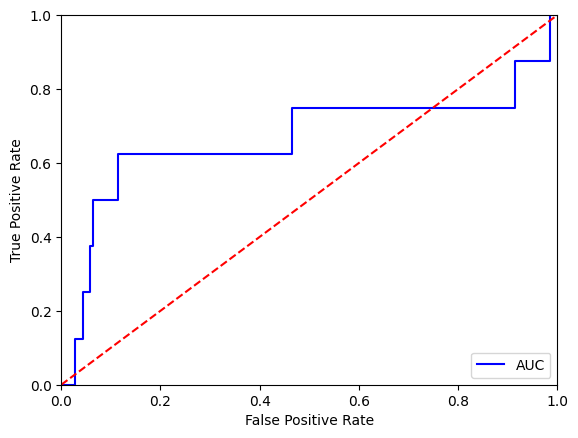

In [30]:
results = {}
# Collects performance metrics for all tasks on test set
for i in range(len(clintox_task)):
    
    valid_datapoints = y_test[:,i] >= 0
    y_test_task = y_test[valid_datapoints,i] 
    y_test_pred_task = y_test_pred[i].detach().numpy()[valid_datapoints,0]
    
    acc = accuracy_score(y_test_task, np.round(y_test_pred_task))
    print('Accuracy for STDNN on Morgan Fingerprint:', acc)
    
    bacc = sklearn.metrics.balanced_accuracy_score(y_test_task, np.round(y_test_pred_task))
    print('Balanced Accuracy for STDNN on Morgan Fingerprint:', bacc)

    f1 = f1_score(y_test_task, np.round(y_test_pred_task), pos_label=1)
    print('F1 for STDNN on Morgan Fingerprint:', f1)

    cfm = sklearn.metrics.confusion_matrix(y_test_task, np.round(y_test_pred_task))
    cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]
    
    tn, fp, fn, tp = cfm.ravel()
    pr = tp / (tp + fp)
    rc = tp / (tp + fn)
    print(' True Positive:', tp)
    print(' True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    
    
    auc = roc_auc_score(y_test_task, y_test_pred_task)
    print('Test ROC AUC ({}):'.format(clintox_task[i]), auc)
    
    results[clintox_task[i]] = [auc, acc, bacc, tn, tp, pr, rc, f1]

    fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test_task, y_test_pred_task)
    plt.plot(fpr, tpr, 'b', label = 'AUC')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Here we have the same results obtained by the reference paper using their model and data splits.

We'll try to improve the performances using the same data splits.

##### GCNN (Using DeepChem )

In [31]:
# Function to evaluate model performances
def evaluate_deepchem(y_true, y_pred):
    # Convert continuous targets to binary targets using a threshold of 0.5
    y_true_binary = y_true
    y_pred_binary = y_pred

    print(y_true_binary.shape, y_pred_binary.shape)

    # Calculate evaluation metrics on binary targets
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true_binary, y_pred_binary)
    bacc = balanced_accuracy_score(y_true_binary, y_pred_binary)

    # Create a list of metric names and values
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Balanced Accuracy"]
    values = [accuracy, precision, recall, f1, roc_auc, bacc]

    # Create a list of lists for tabulating
    table = [metrics, values]

    # Display the table
    print(tabulate(table, headers='firstrow'))

    # Create a heatmap of the confusion matrix
    sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])

    # Add labels and title
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

In [32]:
# Create features for the Graph Neural Network
def featurize(data, tasks):
    # Extract the smiles and target columns
    smiles = data['smiles'].values
    targets = data[tasks].values

    # Define the featurizer
    featurizer = dc.feat.graph_features.ConvMolFeaturizer()

    # Featurize the molecules
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    featurized_mols = featurizer.featurize(mols)

    # Convert the dataset to DeepChem's NumpyDataset format
    dataset = dc.data.NumpyDataset(X=featurized_mols, y=targets)

    return dataset

In [33]:
# Get data with features for the GCNN
train, valid, test = [featurize(data, CLINTOX_TARGET) for data in [train_data, valid_data, test_data]]

In [34]:
# Define the model
model = dc.models.GraphConvModel(
    len(clintox_task),
    batch_size=512,
    mode='classification',
    n_classes=2,
)

# Train the model for 50 epochs
num_epochs = 50
losses = []
for i in range(num_epochs):
    loss = model.fit(train, nb_epoch=1)
    print("Epoch %d loss: %f" % (i+1, loss))
    losses.append(loss)

Epoch 1 loss: 0.851250
Epoch 2 loss: 0.402715
Epoch 3 loss: 0.237783
Epoch 4 loss: 0.193507
Epoch 5 loss: 0.178310
Epoch 6 loss: 0.163541
Epoch 7 loss: 0.148672
Epoch 8 loss: 0.139362
Epoch 9 loss: 0.126951
Epoch 10 loss: 0.118101
Epoch 11 loss: 0.111144
Epoch 12 loss: 0.101208
Epoch 13 loss: 0.096021
Epoch 14 loss: 0.088368
Epoch 15 loss: 0.083736
Epoch 16 loss: 0.077537
Epoch 17 loss: 0.072624
Epoch 18 loss: 0.069245
Epoch 19 loss: 0.064822
Epoch 20 loss: 0.062238
Epoch 21 loss: 0.059588
Epoch 22 loss: 0.056256
Epoch 23 loss: 0.055033
Epoch 24 loss: 0.054103
Epoch 25 loss: 0.051717
Epoch 26 loss: 0.048775
Epoch 27 loss: 0.047328
Epoch 28 loss: 0.047047
Epoch 29 loss: 0.044468
Epoch 30 loss: 0.043857
Epoch 31 loss: 0.041813
Epoch 32 loss: 0.039685
Epoch 33 loss: 0.039181
Epoch 34 loss: 0.031130
Epoch 35 loss: 0.036704
Epoch 36 loss: 0.035506
Epoch 37 loss: 0.035234
Epoch 38 loss: 0.034451
Epoch 39 loss: 0.034657
Epoch 40 loss: 0.031703
Epoch 41 loss: 0.031090
Epoch 42 loss: 0.031055
E

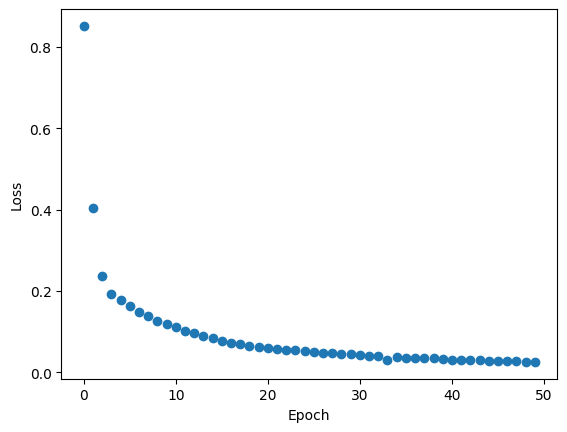

In [35]:
# Plot loss over epochs
plt.ylabel("Loss")
plt.xlabel("Epoch")
x = range(num_epochs)
y = losses
plt.scatter(x, y)
plt.show()

(148,) (148,)
  Accuracy    Precision    Recall    F1 Score    ROC AUC    Balanced Accuracy
----------  -----------  --------  ----------  ---------  -------------------
  0.939189            0         0           0   0.496429             0.496429


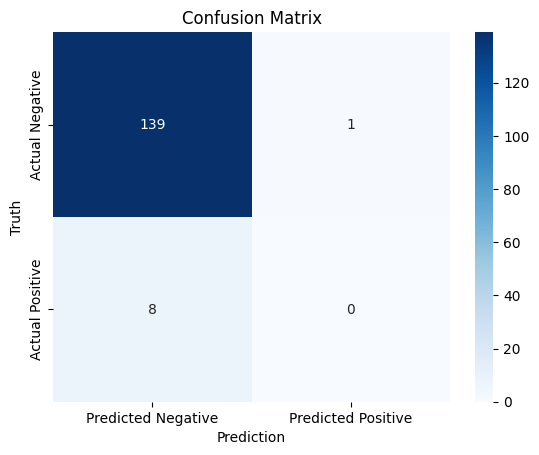

In [36]:
# Manipulate the data to use our scoring function
ytest = test.to_dataframe()['y'].values
ypred = model.predict(test).reshape((148, 2))
ytest_binary = (ytest > 0.5).astype(int)

arg_m = np.argmax(ypred, axis=1)
ypred_binary = np.where(arg_m > 0.5, 1, 0)

# Evaluate the model
evaluate_deepchem(ytest_binary, ypred_binary)

The results obtained from the base GCNN are not very promising if compared to the ones from the STDNN and from the ones found on the reference papers.

#### Deep Purpose

In [37]:
# Function to evaluate model performances
def evaluate_model(model, test):
    y_true = np.array(test['Label'])
    y_pred = np.array(model.predict(test))

    # Convert continuous targets to binary targets using a threshold of 0.5
    y_true_binary = (y_true > 0.5).astype(int)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate evaluation metrics on binary targets
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true_binary, y_pred_binary)
    bacc = balanced_accuracy_score(y_true_binary, y_pred_binary)

    # Create a list of metric names and values
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Balanced Accuracy"]
    values = [accuracy, precision, recall, f1, roc_auc, bacc]

    # Create a list of lists for tabulating
    table = [metrics, values]

    # Display the table
    print(tabulate(table, headers='firstrow'))

    # Create a heatmap of the confusion matrix
    sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])

    # Add labels and title
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

In [38]:
# Get X and y for train, test, val splits
X_train = train_data['smiles']
y_train = train_data[CLINTOX_TARGET]

X_test = test_data['smiles']
y_test = test_data[CLINTOX_TARGET]

X_valid = valid_data['smiles']
y_valid = valid_data[CLINTOX_TARGET]

In [39]:
def train_model(X_train, y_train, X_test, y_test, X_valid, y_valid, drug_encoding='Morgan'):
    # Get fingerprints for train, test, val splits
    train = utils.data_process(X_drug=X_train, y=y_train, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)
    val = utils.data_process(X_drug=X_valid, y=y_valid, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)
    test = utils.data_process(X_drug=X_test, y=y_test, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)

    # Configuring the model
    config = utils.generate_config(drug_encoding=drug_encoding, mlp_hidden_dims_drug=[32, 16, 8], train_epoch=40, LR=0.001, batch_size=124)

    model_dp = CompoundPred.model_initialize(**config)

    # Training the model
    print('\n\n', '-' * 30)
    print(f'Model training using {drug_encoding} fingerprint:')
    model_dp.train(train, val, test, verbose=1)

    # Evaluating the model
    evaluate_model(model_dp, test)
    print('-' * 30)


Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Morgan fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.67594. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.52292 , AUPRC: 0.12658 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.25854. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.61886 , AUPRC: 0.21123 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.32405. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.60660 , AUPRC: 0.

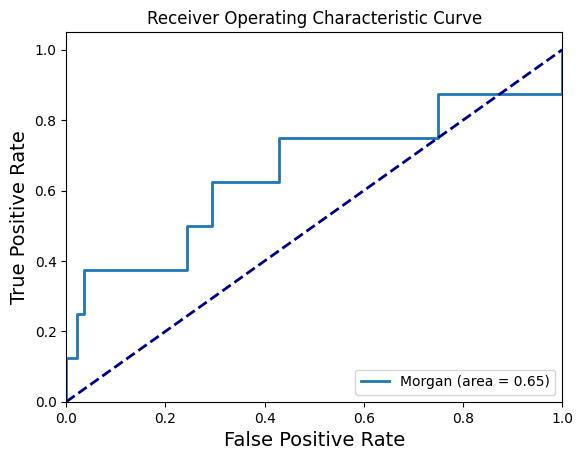

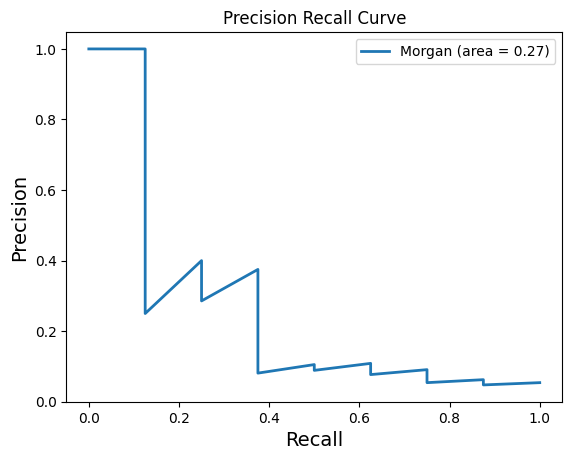

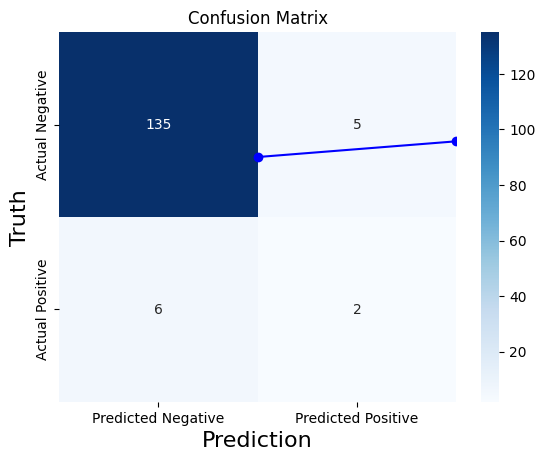

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Pubchem fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68584. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.64658 , AUPRC: 0.18823 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.31598. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.66204 , AUPRC: 0.23644 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.26038. Total time 0.0 hours
Validation at Epoc

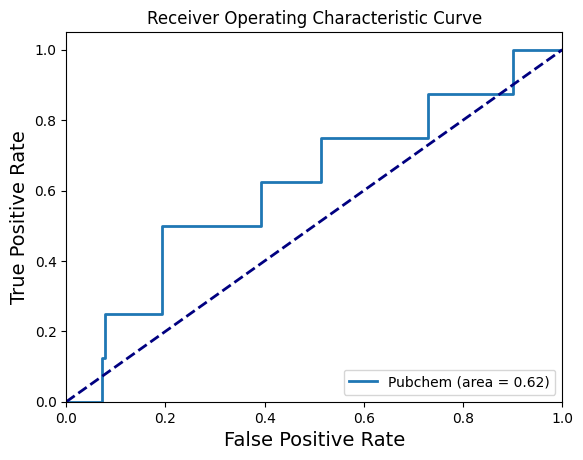

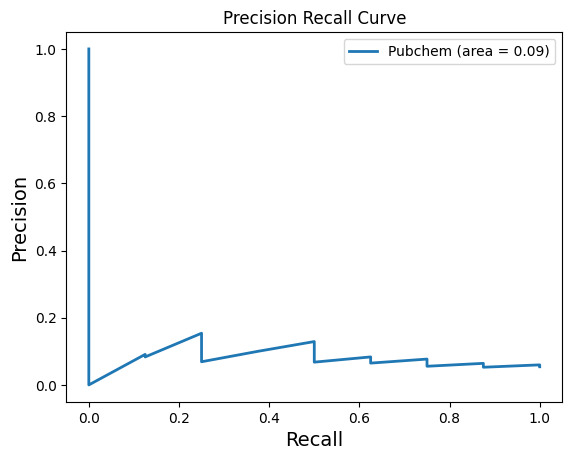

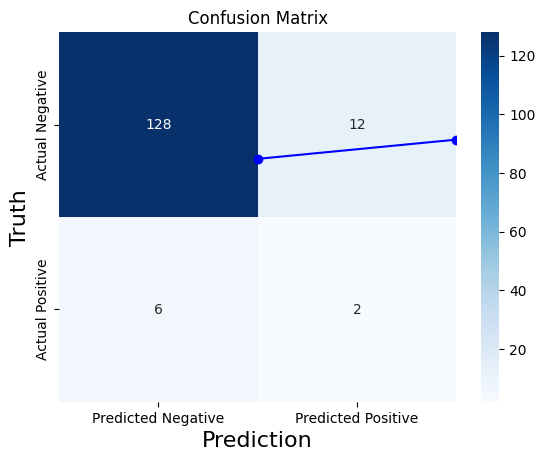

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
rdkit not found this smiles: [Se] convert to all 0 features
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Daylight fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.71121. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.60447 , AUPRC: 0.12009 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.21078. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.65405 , AUPRC: 0.13990 , F1: 0.0
Training at Epoch 3 iteration

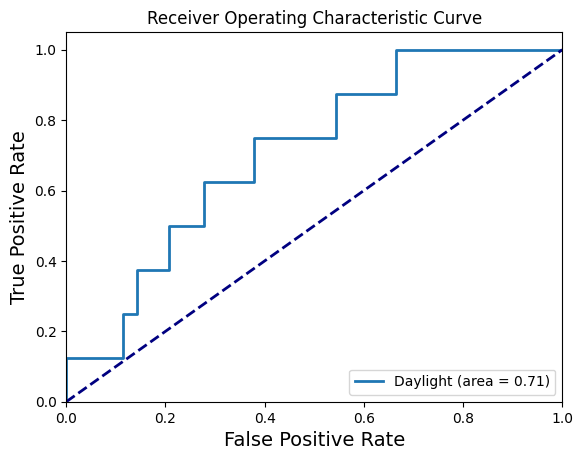

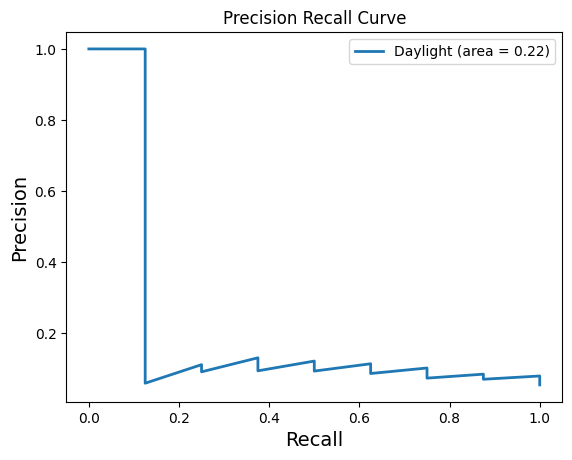

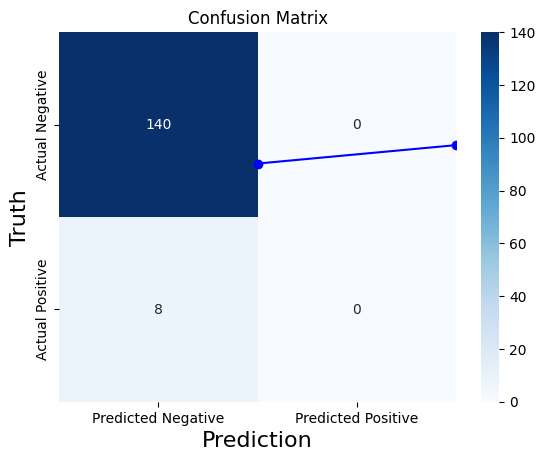

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using rdkit_2d_normalized fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68705. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.59434 , AUPRC: 0.13527 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.26411. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.76652 , AUPRC: 0.31426 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.21720. Total time 0.0 hours
Valida

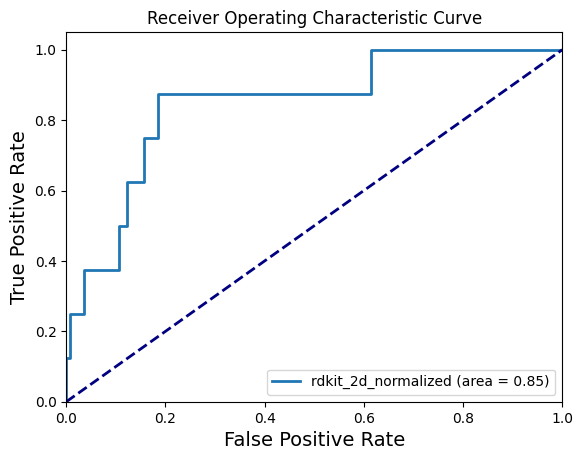

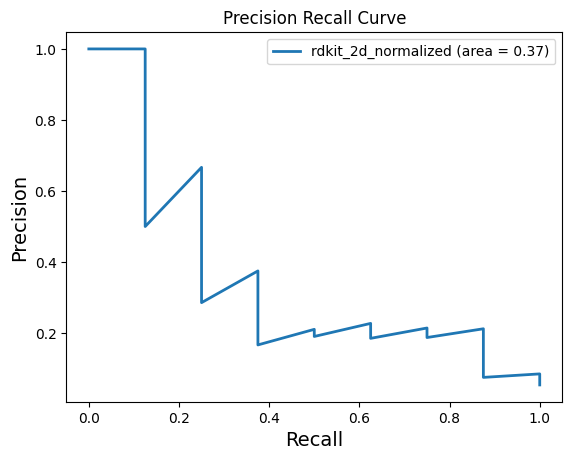

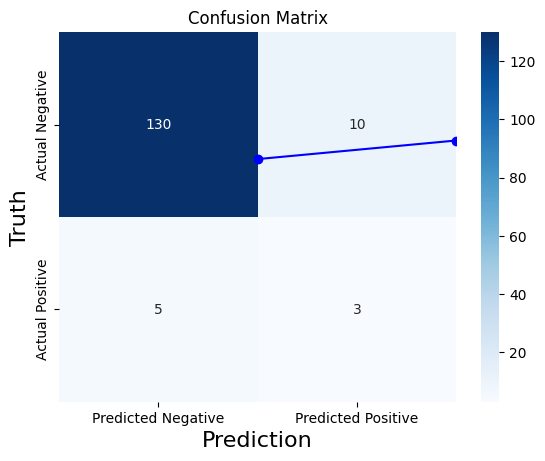

------------------------------


[None, None, None, None]

In [40]:
# Test DeepPurpode models using different drug encodings (seen in class)
drug_encodings = ['Morgan', 'Pubchem', 'Daylight', 'rdkit_2d_normalized']

[train_model(X_train, y_train, X_test, y_test, X_valid, y_valid, encoding) for encoding in drug_encodings]

The best fingerprint, between the ones seen in class, in general seems to be Morgan fingerprint

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using ESPF fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68528. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.95628 , AUPRC: 0.78517 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.29781. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.95575 , AUPRC: 0.89339 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.19046. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.96855 , AUPRC: 0.90

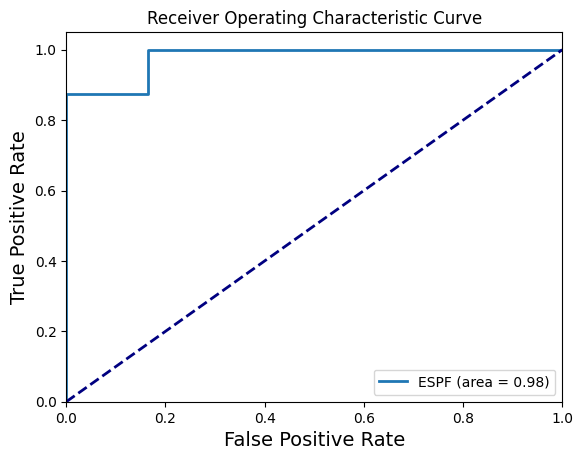

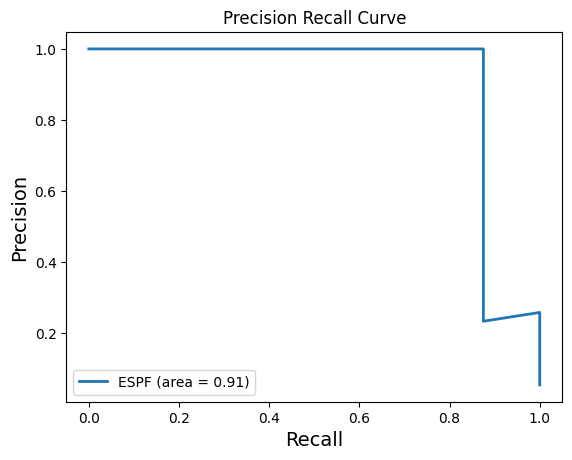

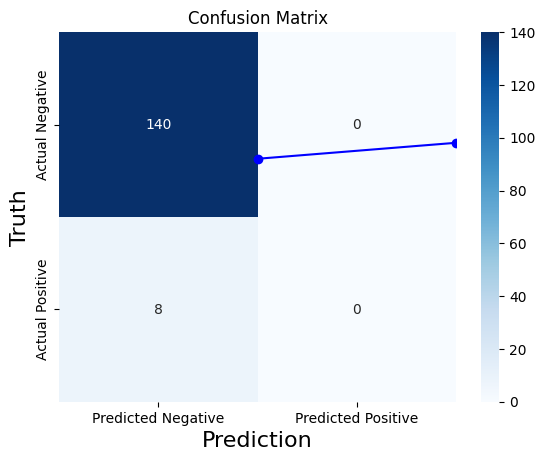

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using ErG fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68303. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.49999 , AUPRC: 0.23296 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.19514. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.76119 , AUPRC: 0.38225 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.29071. Total time 0.0 hours
Validation at Epoch 3 

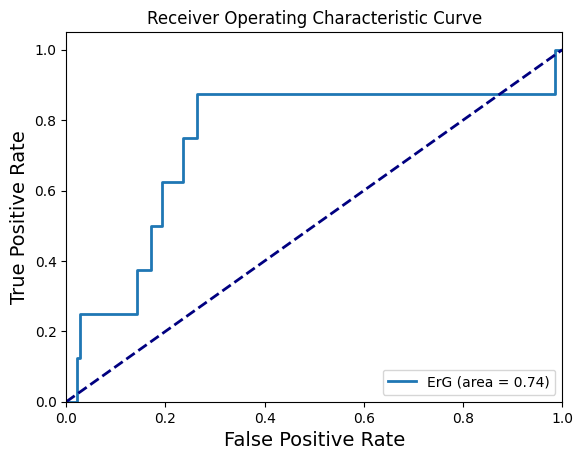

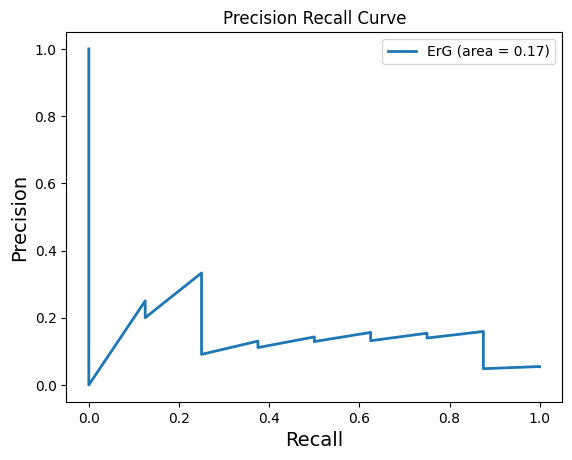

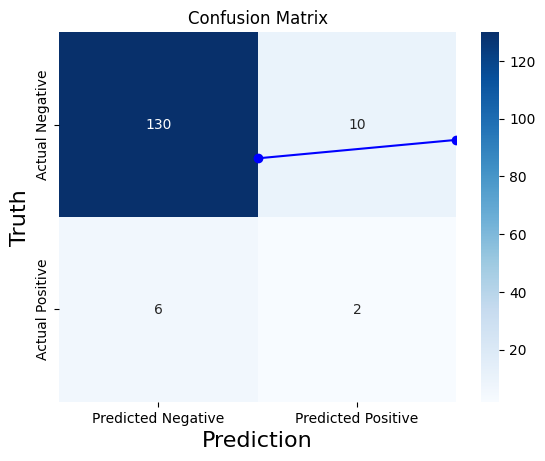

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68525. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.75639 , AUPRC: 0.18887 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.33907. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.93496 , AUPRC: 0.53723 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.37785. Total time 0.00111 hours
Validation at 

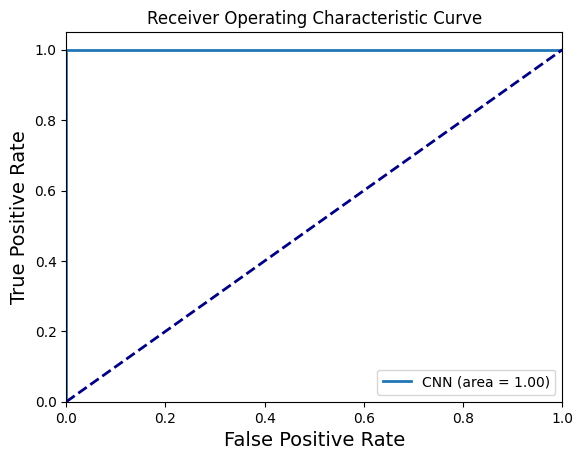

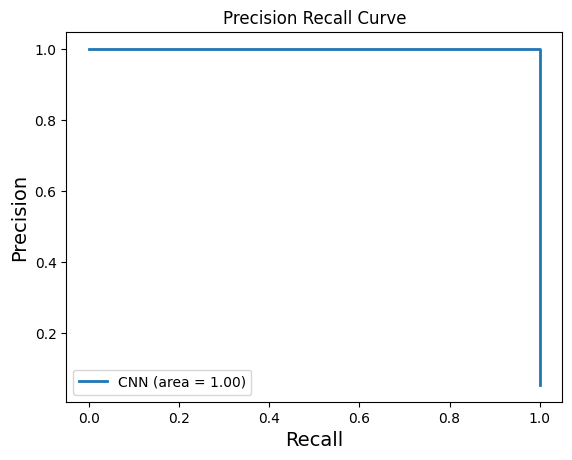

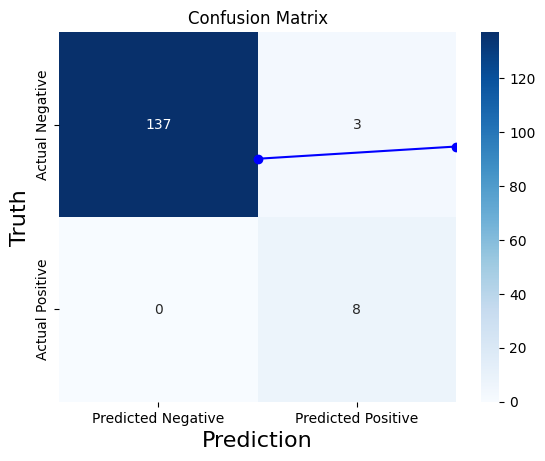

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Transformer fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69290. Total time 0.00027 hours
Validation at Epoch 1 , AUROC: 0.48267 , AUPRC: 0.09201 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.25652. Total time 0.00472 hours
Validation at Epoch 2 , AUROC: 0.56316 , AUPRC: 0.12049 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.32102. Total time 0.00888 hours
Va

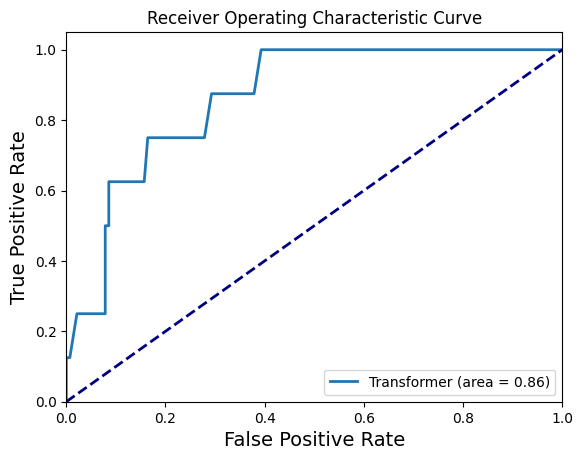

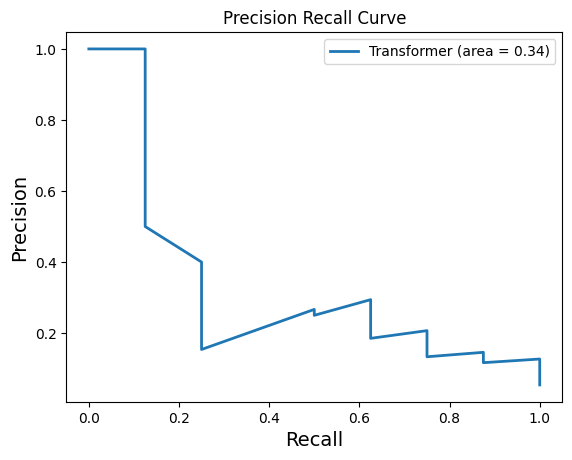

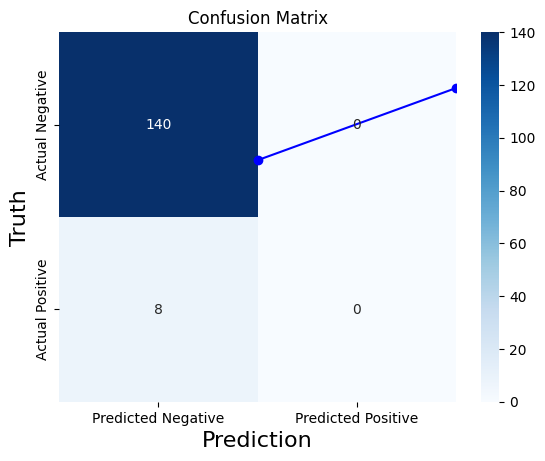

------------------------------


[None, None, None, None]

In [41]:
# Test DeepPurpode models using different drug encodings (not seen in class)
drug_encodings = ['ESPF', 'ErG', 'CNN', 'Transformer']

[train_model(X_train, y_train, X_test, y_test, X_valid, y_valid, encoding) for encoding in drug_encodings]

ESPF and CNN drug encodings work really well, with the CNN drug encoding working incredibly well!

We reached scores very close to the best ones reported in the reference paper but without adding any feature and using just data from Clintox dataset.

The Transformer drug encoding seems to be so complex that it just overfits the training data.

##### Add Features from RDkit

In [42]:
# Split data into training, testing and valuidation sets
train_data = clintox_df[0]
test_data  = clintox_df[1]
valid_data = clintox_df[2]

In [43]:
#Calculating Molecules, LogP, MW, RB, AromaticAtoms, HeavyAtoms, AP descriptors
def compute_descriptors(df):
    dfc = df.copy()
    dfc["ROMol"] = dfc["smiles"].apply(lambda x: Chem.MolFromSmiles(x))
    dfc['SmilesLength'] = [len(smile) for smile in dfc['smiles']]
    dfc['MolLogP'] = [Descriptors.MolLogP(mol) for mol in dfc['ROMol']]
    dfc['ExactMolWt'] = [Descriptors.ExactMolWt(mol) for mol in dfc['ROMol']]
    dfc['RB'] =  [Descriptors.NumRotatableBonds(mol) for mol in dfc['ROMol']]
    dfc['AromaticAtoms'] = [len(mol.GetAromaticAtoms()) for mol in dfc['ROMol']]
    dfc['HeavyAtoms'] = [mol.GetNumHeavyAtoms() for mol in dfc['ROMol']]
    dfc['AP'] = dfc['AromaticAtoms'] / dfc['HeavyAtoms']
    
    return dfc

In [44]:
# Compute features on the already splitted data
train_features, test_features, valid_features = [compute_descriptors(data) for data in [train_data, test_data, valid_data]]

In [45]:
# Check the sets with the new features
train_features.head(3)

smiles  FDA_APPROVED  CT_TOX   
755  CC(C)CN(C[C@H]([C@H](Cc1ccccc1)NC(=O)O[C@H]2CC...             1       0  \
96                             C1[C@H](C(=O)NO1)[NH3+]             1       0   
671  CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...             0       1   

                                                 ROMol  SmilesLength  MolLogP   
755  <rdkit.Chem.rdchem.Mol object at 0x0000019EAF9...            72  2.40280  \
96   <rdkit.Chem.rdchem.Mol object at 0x0000019EAF9...            23 -2.34170   
671  <rdkit.Chem.rdchem.Mol object at 0x0000019EAF9...            73  5.89378   

     ExactMolWt  RB  AromaticAtoms  HeavyAtoms        AP  
755  505.224657  11             12          35  0.342857  
96   103.050204   0              0           7  0.000000  
671  469.190260   3             29          36  0.805556

In [46]:
# Get X and y for train, test, val splits
features = ['smiles', 'FDA_APPROVED', 'ROMol', 'SmilesLength', 'MolLogP', 'ExactMolWt', 'RB', 'AromaticAtoms', 'HeavyAtoms', 'AP']

X_train = train_features[features]
y_train = train_features[CLINTOX_TARGET]

X_test = test_features[features]
y_test = test_features[CLINTOX_TARGET]

X_valid = valid_features[features]
y_valid = valid_features[CLINTOX_TARGET]

In [47]:
# Concatenate the features to make them compatible with DeepPurpose
X_train_c = np.concatenate([X_train['smiles']] + [X_train.drop(['smiles', 'ROMol'], axis=1).values.flatten()], axis=0)
X_test_c = np.concatenate([X_test['smiles']] + [X_test.drop(['smiles', 'ROMol'], axis=1).values.flatten()], axis=0)
X_valid_c = np.concatenate([X_valid['smiles']] + [X_valid.drop(['smiles', 'ROMol'], axis=1).values.flatten()], axis=0)

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Morgan fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68559. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.55437 , AUPRC: 0.21501 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.26008. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.64498 , AUPRC: 0.29480 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.23822. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.57622 , AUPRC: 0.

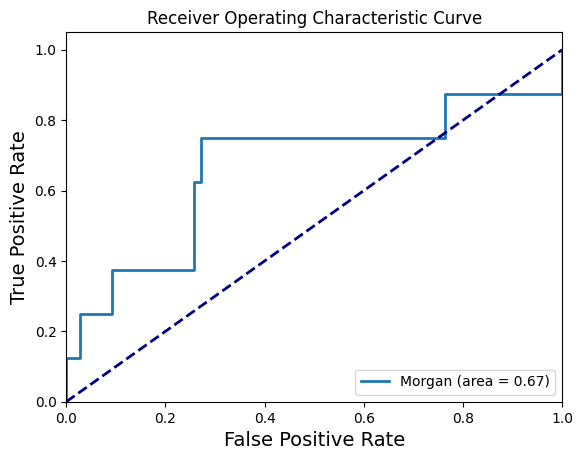

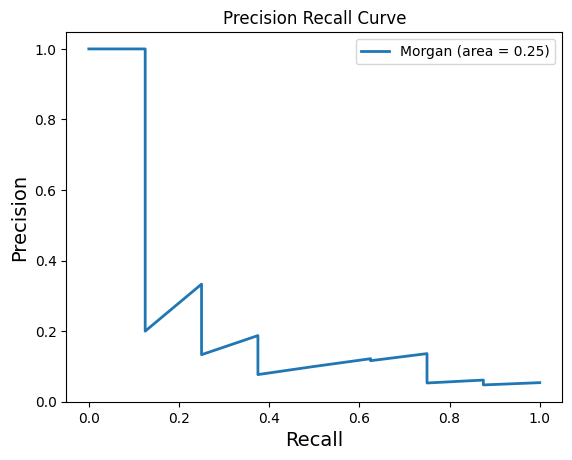

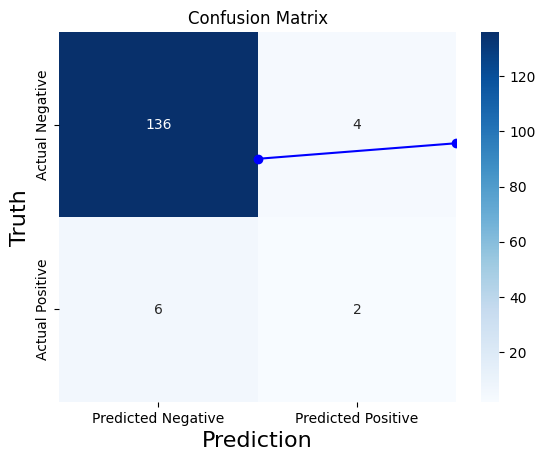

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Pubchem fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.67327. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.74307 , AUPRC: 0.29160 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.29840. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.60447 , AUPRC: 0.18018 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.27210. Total time 0.0 hours
Validation at Epoc

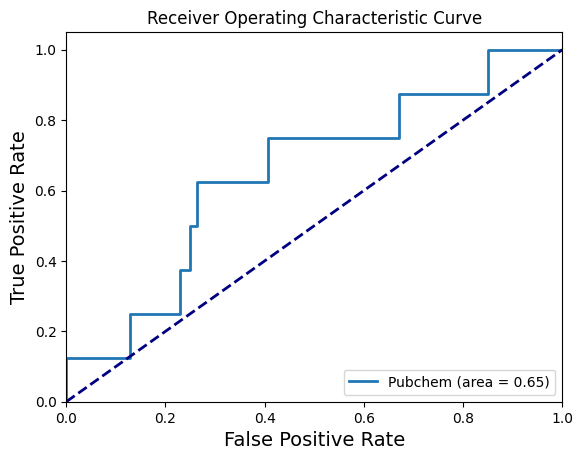

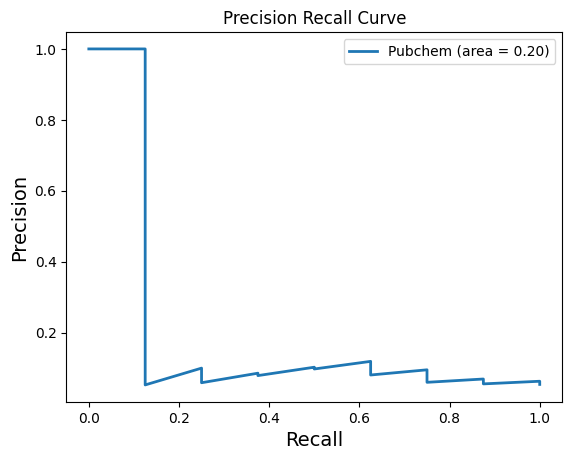

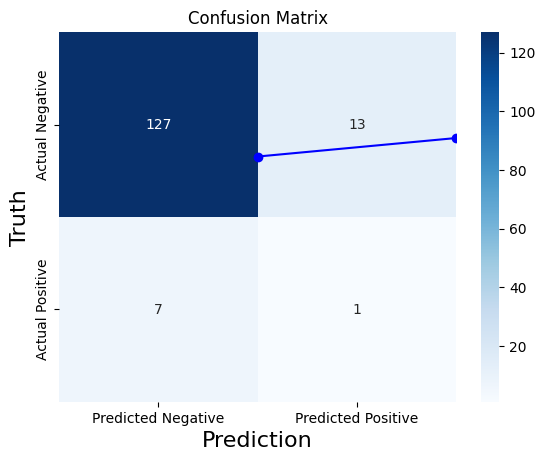

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
rdkit not found this smiles: [Se] convert to all 0 features
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Daylight fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69098. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.53518 , AUPRC: 0.10426 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.22455. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.61833 , AUPRC: 0.12164 , F1: 0.0
Training at Epoch 3 iteration

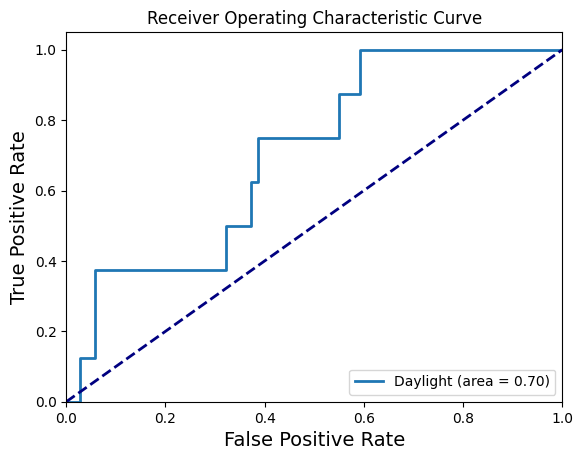

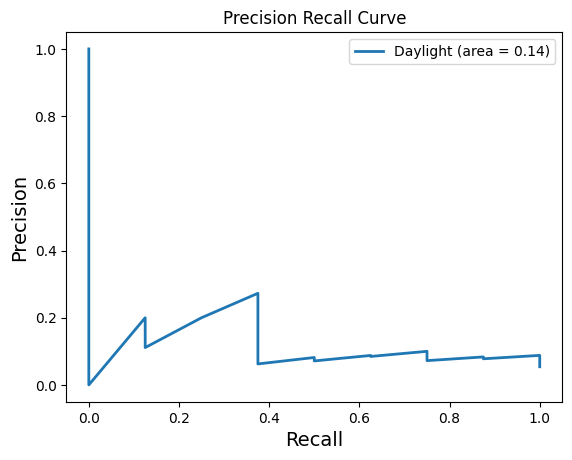

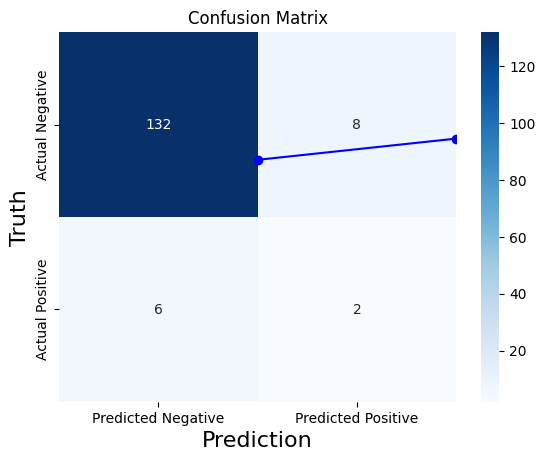

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using rdkit_2d_normalized fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68270. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.44989 , AUPRC: 0.10524 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.25869. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.71268 , AUPRC: 0.19068 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.29190. Total time 0.0 hours
Valida

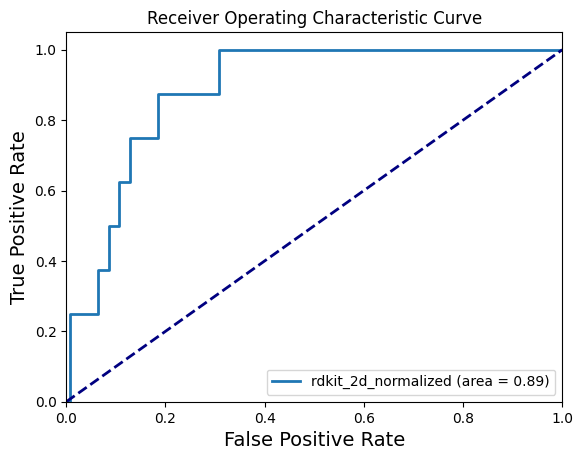

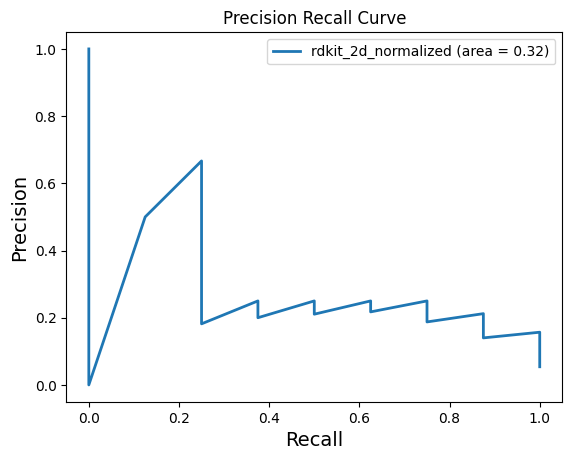

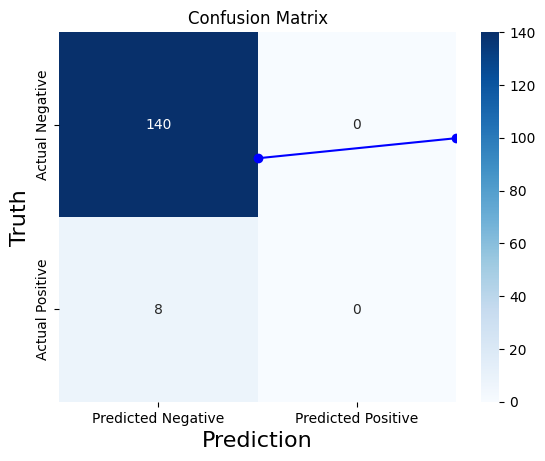

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using ESPF fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68379. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.88752 , AUPRC: 0.79596 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.26098. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.93176 , AUPRC: 0.86052 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.24314. Total time 0.0 hours
Validation at Epoch 3

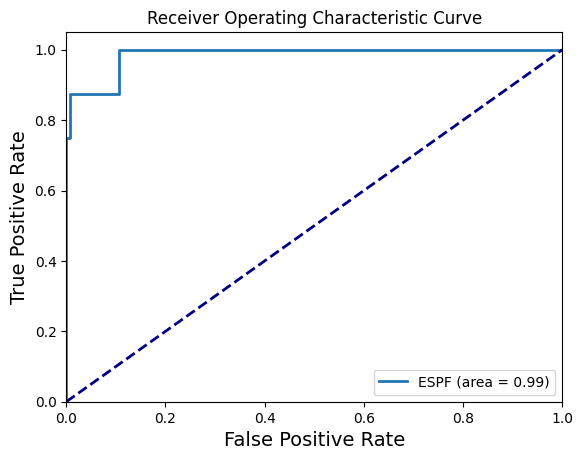

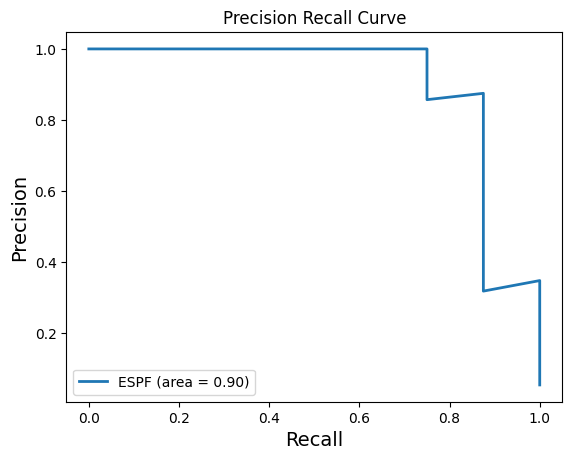

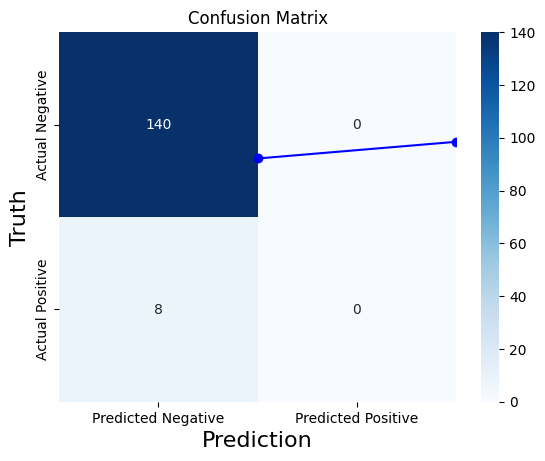

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using ErG fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70632. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.55437 , AUPRC: 0.14246 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.26873. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.66044 , AUPRC: 0.19293 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.31185. Total time 0.0 hours
Validation at Epoch 3 

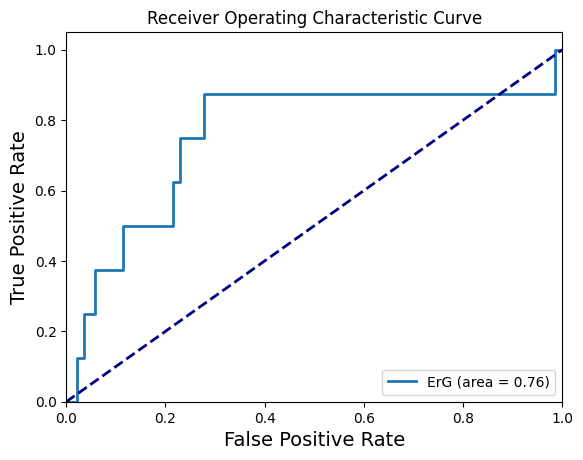

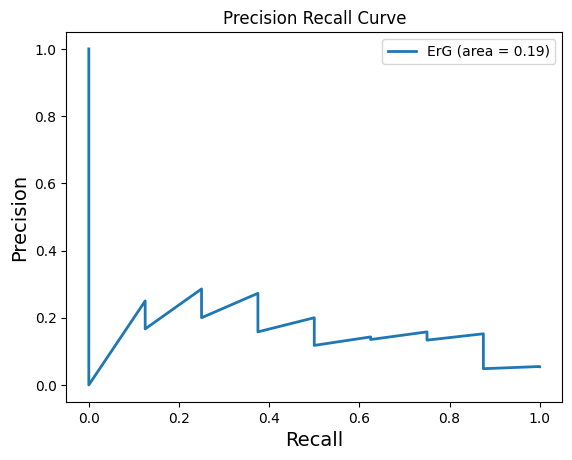

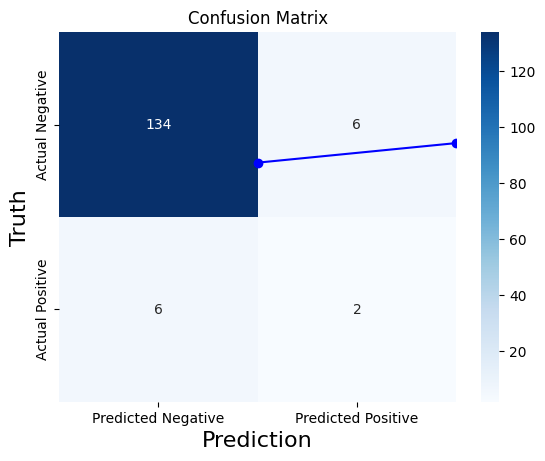

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69895. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.80437 , AUPRC: 0.20652 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.32844. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.90991 , AUPRC: 0.35673 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.36135. Total time 0.00111 hours
Validation at 

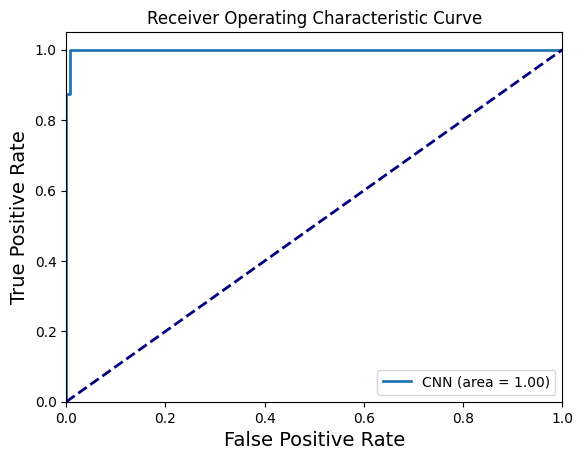

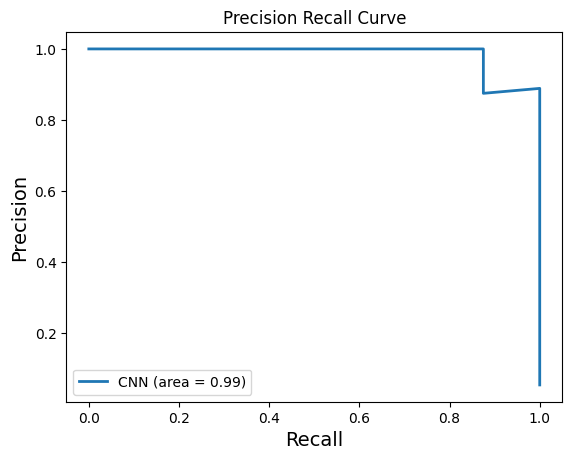

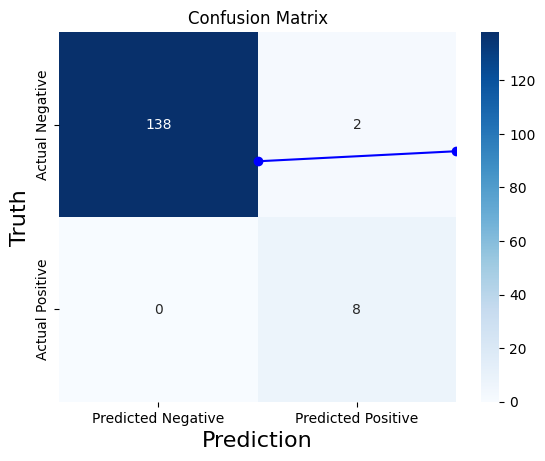

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Transformer fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69750. Total time 0.00027 hours
Validation at Epoch 1 , AUROC: 0.41950 , AUPRC: 0.08300 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.12855. Total time 0.00472 hours
Validation at Epoch 2 , AUROC: 0.46641 , AUPRC: 0.09875 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.21549. Total time 0.00916 hours
Va

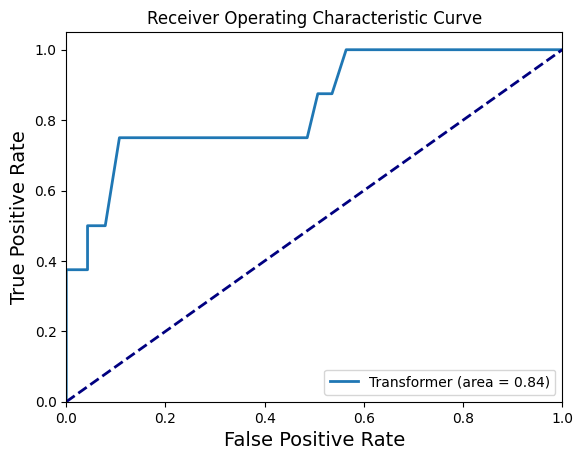

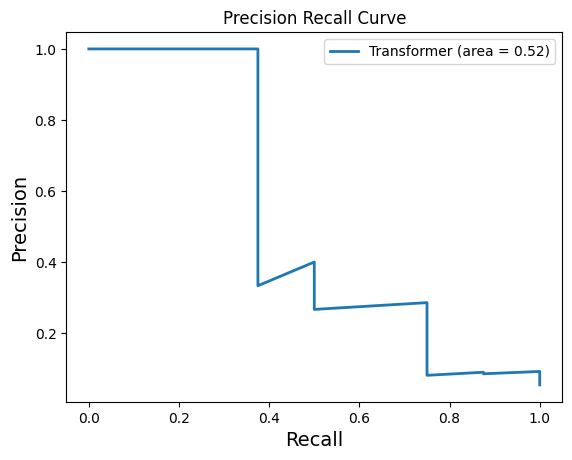

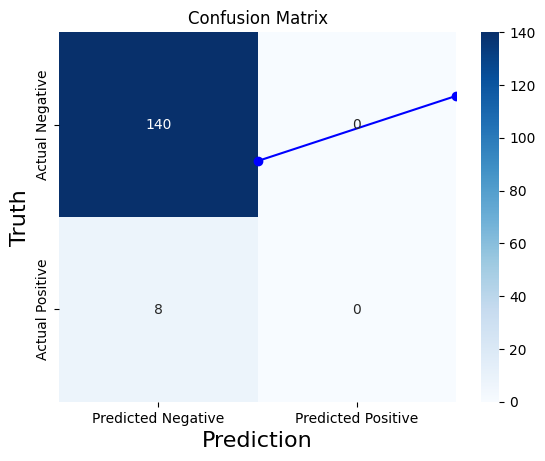

------------------------------


[None, None, None, None, None, None, None, None]

In [48]:
# Train the DeepPurpose model using all the new features
drug_encodings = ['Morgan', 'Pubchem', 'Daylight', 'rdkit_2d_normalized', 'ESPF', 'ErG', 'CNN', 'Transformer']

[train_model(X_train_c, y_train, X_test_c, y_test, X_valid_c, y_valid, encoding) for encoding in drug_encodings]

As seen in the test with the models using just smiles as features, the best drug encodings seem to be ESPF and CNN, with CNN as the best one.

It seems that adding these features didn't improve the results.

We'll try to perform feature selection to see if we can remove some confounder features and improve the results obtained just from using the smiles.

##### Features Selection

In [49]:
# Get again X and y for train, test, val splits
X_train = train_features[features]
y_train = train_features[CLINTOX_TARGET]

X_test = test_features[features]
y_test = test_features[CLINTOX_TARGET]

X_valid = valid_features[features]
y_valid = valid_features[CLINTOX_TARGET]

In [50]:
# Try feature selection stuff
# Separate the target variable (if applicable)
def feature_selection(X_train, X_test, X_valid, y_train, y_test, y_valid, num_features=3):
    data_x, data_y = [X_train, X_test, X_valid], [y_train, y_test, y_valid]

    x1, x2, x3, y1 = data_x[0].copy(),  data_x[1].copy(), data_x[2].copy(), data_y[0].copy()

    # Remove the 'smiles'  and 'ROMol' columns from features
    x1 = x1.drop(['smiles', 'ROMol'], axis=1)  
    x2 = x2.drop(['smiles', 'ROMol'], axis=1) 
    x3 = x3.drop(['smiles', 'ROMol'], axis=1) 

    # Create a RandomForestRegressor as the estimator for RFE
    estimator = RandomForestRegressor()

    # Perform Recursive Feature Elimination (RFE)
    rfe = RFE(estimator, n_features_to_select=num_features)  # Select the top num_features features
    X_selected = rfe.fit_transform(x1, y1)

    # Get the column names of the selected features
    selected_feature_names = x1.columns[rfe.support_].tolist()

    # Create a DataFrame with the selected features
    df_selected = pd.DataFrame(X_selected, columns=selected_feature_names)

    # Get best features also on validation and testing sets
    x2 = data_x[1][selected_feature_names]
    x3 = data_x[2][selected_feature_names]

    # Concatenate the selected features DataFrame with the 'smiles' DataFrame
    df_train = pd.concat([pd.DataFrame(data_x[0]['smiles'], columns=['smiles']), df_selected], axis=1)
    df_train = np.concatenate([df_train['smiles']] + [df_train.drop(['smiles'], axis=1).values.flatten()], axis=0)

    df_test = pd.concat([pd.DataFrame(data_x[1]['smiles'], columns=['smiles']), x2], axis=1)
    df_test = np.concatenate([df_test['smiles']] + [df_test.drop(['smiles'], axis=1).values.flatten()], axis=0)

    df_val = pd.concat([pd.DataFrame(data_x[2]['smiles'], columns=['smiles']), x3], axis=1)
    df_val = np.concatenate([df_val['smiles']] + [df_val.drop(['smiles'], axis=1).values.flatten()], axis=0)
    selected_feature_names = selected_feature_names + ['smiles']
    
    return df_train, df_test, df_val, selected_feature_names


In [51]:
# Select the 5 most important features
X_train_selected, X_test_selected, X_valid_selected, selected_feature_names = feature_selection(X_train, X_test, X_valid, y_train, y_test, y_valid, 5)

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using ESPF fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.67699. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.95042 , AUPRC: 0.77694 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.22927. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.97814 , AUPRC: 0.89138 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.25551. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.97228 , AUPRC: 0.89

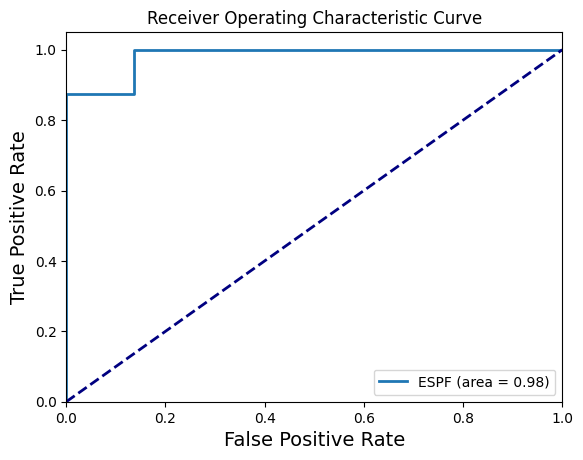

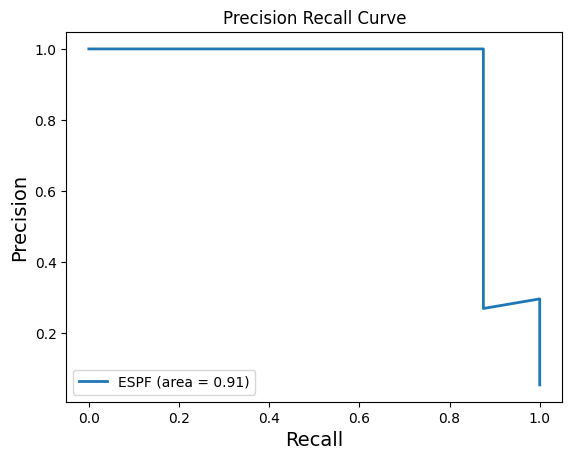

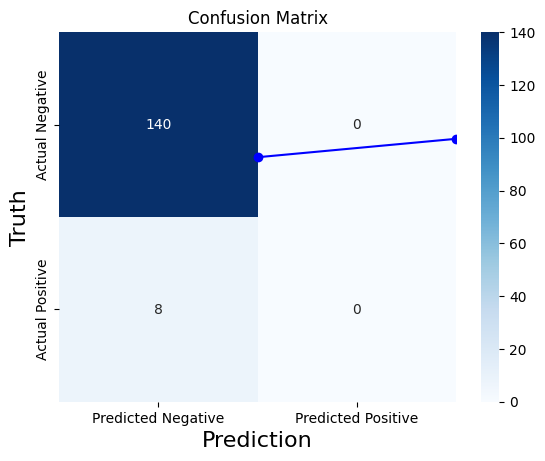

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69017. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.84488 , AUPRC: 0.24572 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.19558. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.91844 , AUPRC: 0.38965 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.29339. Total time 0.00083 hours
Validation at 

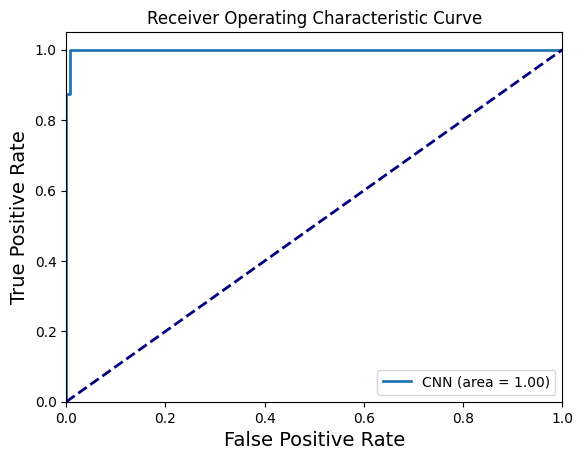

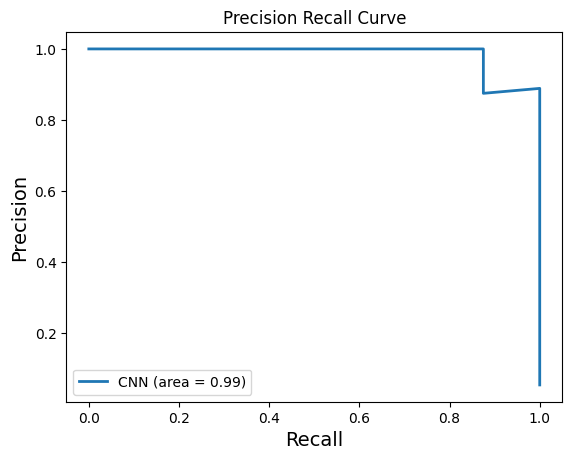

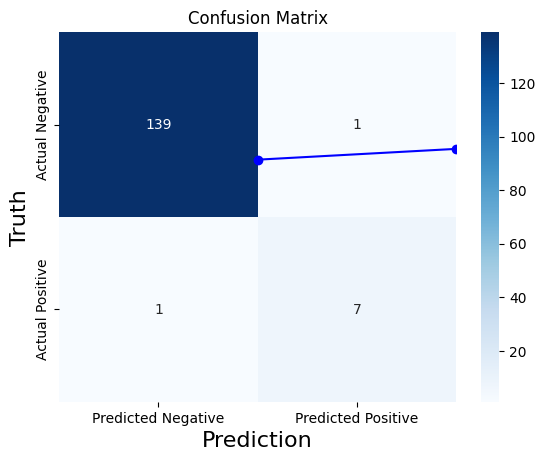

------------------------------


[None, None]

In [52]:
# Train the DeepPurpose model using all the 5 most important features and using the 2 best fingerprints
drug_encodings = ['ESPF', 'CNN']

[train_model(X_train_selected, y_train, X_test_selected, y_test, X_valid_selected, y_valid, encoding) for encoding in drug_encodings]

Using just the 5 most important features we reach values very near to 1 in all our evaluation metrics. That is quite unlikely in a real environment, and is probably due to the very small number of samples in the testing set (and also in the validation one).

As we want to compare the results with the ones obtained on the reference paper, we can't modify the data and the splits, to guarantee a fair comparison.

Just for curiosity we'll try to select even less features (just 3) to see if we can get a similar results with less features.

Note that no data-leakage occurred, so the comparison is in fact fair.

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using ESPF fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69614. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.89179 , AUPRC: 0.71175 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.17440. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.94029 , AUPRC: 0.84334 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.20879. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.96162 , AUPRC: 0.87

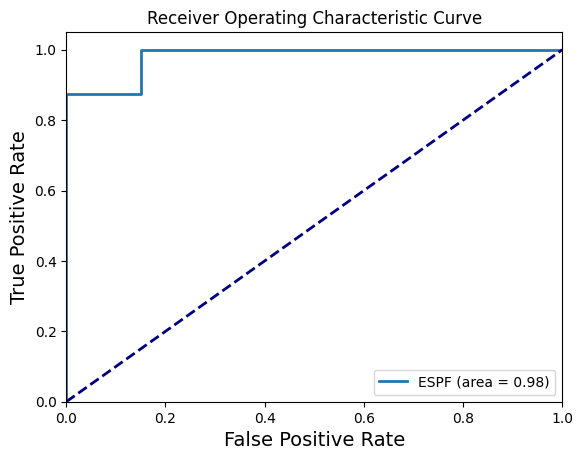

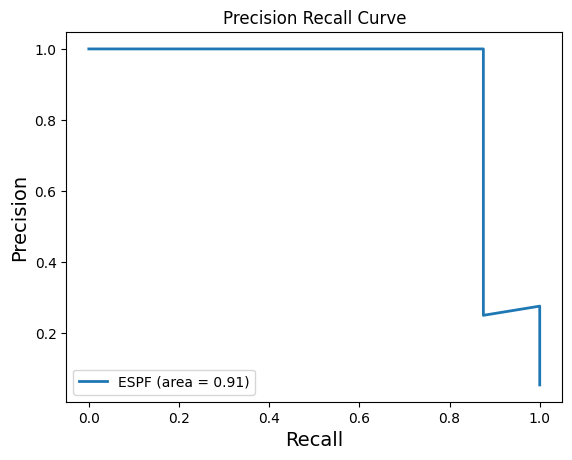

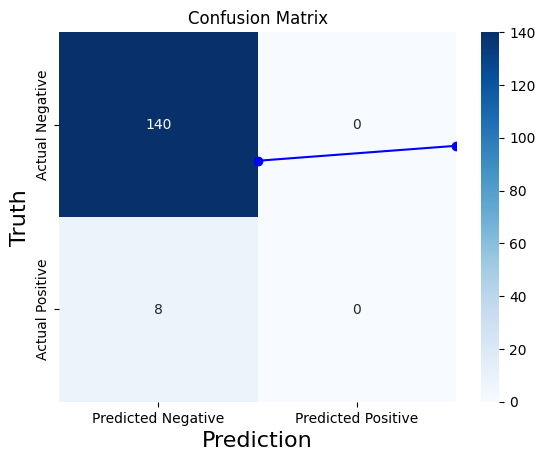

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70479. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.82249 , AUPRC: 0.23359 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.27819. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.89978 , AUPRC: 0.35317 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.20557. Total time 0.00083 hours
Validation at 

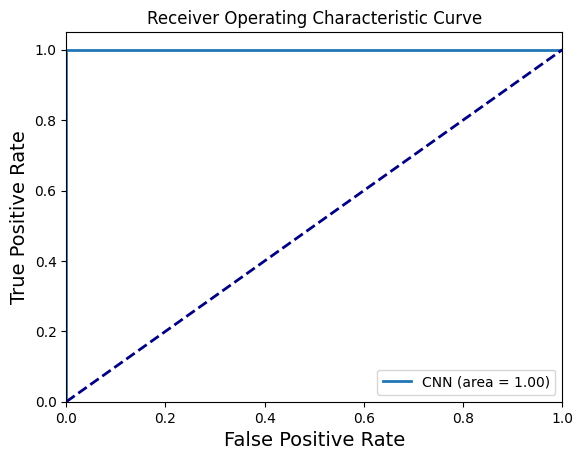

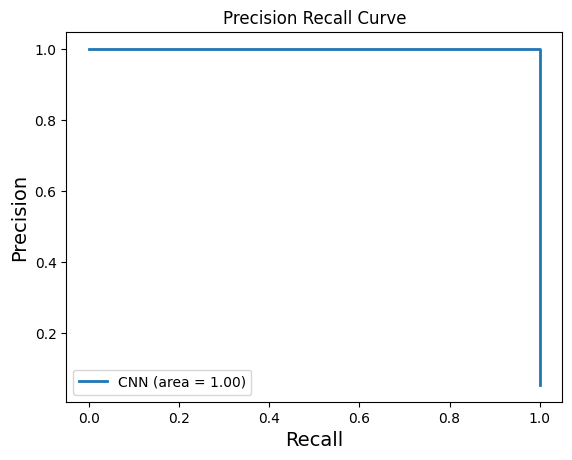

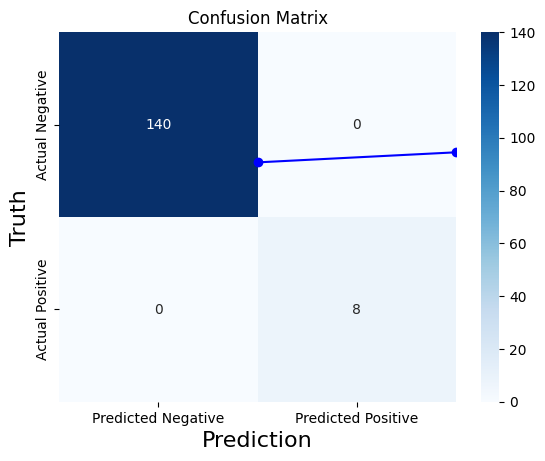

------------------------------


[None, None]

In [53]:
# Select the 3 most important features
X_train_selected, X_test_selected, X_valid_selected, selected_feature_names = feature_selection(X_train, X_test, X_valid, y_train, y_test, y_valid, 3)

# Train the DeepPurpose model using all the 5 most important features and using the 2 best fingerprints
drug_encodings = ['ESPF', 'CNN']

[train_model(X_train_selected, y_train, X_test_selected, y_test, X_valid_selected, y_valid, encoding) for encoding in drug_encodings]

In [60]:
selected_feature_names

['FDA_APPROVED', 'MolLogP', 'ExactMolWt', 'smiles']

Using just 3 features we get slightly worse results than with 5 features, but still very good ones, and requiring even less features to use the model.

#### Cross-validation
Perform cross-validation on the best model (DeepPurpose with CNN drug encoding)

In [54]:
def train_model_crossval(X_train, y_train, X_test, y_test, X_valid, y_valid, drug_encoding='CNN', mlp_hidden_dims_drug=[32, 16, 8], train_epoch=40, LR=0.001, batch_size=124):
    # Get fingerprints for train, test, val splits
    train = utils.data_process(X_drug=X_train, y=y_train, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)
    val = utils.data_process(X_drug=X_valid, y=y_valid, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)
    test = utils.data_process(X_drug=X_test, y=y_test, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)

    # Configuring the model
    config = utils.generate_config(drug_encoding=drug_encoding, mlp_hidden_dims_drug=mlp_hidden_dims_drug, train_epoch=train_epoch, LR=LR, batch_size=batch_size)

    model_dp = CompoundPred.model_initialize(**config)

    # Training the model
    print('\n\n', '-' * 30)
    print(f'Model training using {drug_encoding} fingerprint:')
    model_dp.train(train, val, test, verbose=1)

    return model_dp

In [55]:
# Perform the cross-validation
def cross_validation(X, y, kfold, drug_encoding='CNN', mlp_hidden_dims_drug=[32, 16, 8], train_epoch=40, LR=0.001, batch_size=124):
    drug_encoding = 'CNN'
    accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = [], [], [], [], [], []
    for train_indices, val_indices in kfold.split(X, y):
        X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        X_train = np.concatenate([X_train['smiles']] + [X_train.drop(['smiles'], axis=1).values.flatten()], axis=0)
        X_val = np.concatenate([X_val['smiles']] + [X_val.drop(['smiles'], axis=1).values.flatten()], axis=0)

        # Train model on X_train and y_train using DeepPurpose
        # Here we give again the training set as validation as it is used just to check how the model is performing, but the actual performances are tested on the validation set, so it is just a work-around to use DeepPurpose
        model = train_model_crossval(X_train, y_train, X_val, y_val, X_val, y_val, drug_encoding=drug_encoding, mlp_hidden_dims_drug=mlp_hidden_dims_drug, train_epoch=train_epoch, LR=LR, batch_size=batch_size)

        X_val_proc = utils.data_process(X_drug=X_val, y=y_val, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)

        # Make predictions on the validation set
        y_pred = model.predict(X_val_proc)

        # Convert continuous targets to binary targets using a threshold of 0.5
        y_pred_binary = (np.array(y_pred) > 0.5).astype(int)
        y_val_binary = (np.array(y_val) > 0.5).astype(int)

        # Calculate evaluation metrics on binary targets
        accuracies.append(accuracy_score(y_val_binary, y_pred_binary))
        precisions.append(precision_score(y_val_binary, y_pred_binary))
        recalls.append(recall_score(y_val_binary, y_pred_binary))
        f1_scores.append(f1_score(y_val_binary, y_pred_binary))
        roc_aucs.append(roc_auc_score(y_val_binary, y_pred_binary))
        balanced_accuracies.append(balanced_accuracy_score(y_val_binary, y_pred_binary))
    
    return accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies

In [56]:
def print_performances(accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies):
    # Calculate mean and standard deviation of the metrics
    # Use 2 standard deviations to catch 95% of the distribution
    mean_accuracy, std_accuracy = np.mean(accuracies), 2*np.std(accuracies)
    mean_precision, std_precision = np.mean(precisions), 2*np.std(precisions)
    mean_recall, std_recall = np.mean(recalls), 2*np.std(recalls)
    mean_f1, std_f1 = np.mean(f1_scores), 2*np.std(f1_scores)
    mean_roc_auc, std_roc_auc = np.mean(roc_aucs), 2*np.std(roc_aucs)
    mean_balanced_accuracy, std_balanced_accuracy = np.mean(balanced_accuracies), 2*np.std(balanced_accuracies)

    # Create a list of metric names and values
    metrics_means, metrics_stds = ["mean Accuracy", "mean Precision", "mean Recall", "mean F1 Score", "mean ROC AUC", "mean Balanced Accuracy"], ["Accuracy std", "Precision std", "Recall std", "F1 Score std", "ROC AUC std", "Balanced Accuracy std"]
    values, stds = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc, mean_balanced_accuracy], [std_accuracy, std_precision, std_recall, std_f1, std_roc_auc, std_balanced_accuracy]

    # Create a list of lists for tabulating
    table_means, table_stds = [metrics_means, values], [metrics_stds, stds]

    # Display the table
    print('Mean results:\n', tabulate(table_means, headers='firstrow'))
    print('Std results:\n', tabulate(table_stds, headers='firstrow'))

In [87]:
# Use the 3 most important features
# Get X and y for train, test, val splits
X_train = train_features[selected_feature_names]
y_train = train_data[CLINTOX_TARGET]

X_test = test_features[selected_feature_names]
y_test = test_data[CLINTOX_TARGET]

X_valid = valid_features[selected_feature_names]
y_valid = valid_data[CLINTOX_TARGET]

# Merge X_train and X_valid to use them in the cross-validation

X = pd.concat([X_train, X_valid], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_valid], axis=0).reset_index(drop=True)

Drug Property Prediction Mode...
in total: 1064 drugs
encoding drug...
unique drugs: 1064
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 266 drugs
encoding drug...
unique drugs: 266
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 266 drugs
encoding drug...
unique drugs: 266
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68183. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.80518 , AUPRC: 0.16691 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.33100. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.87652 , AUPRC: 0.40814 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.41837. Total time 0.00083 hours
Validation at Epoch 3 , AUROC: 0.90640 , AUPR

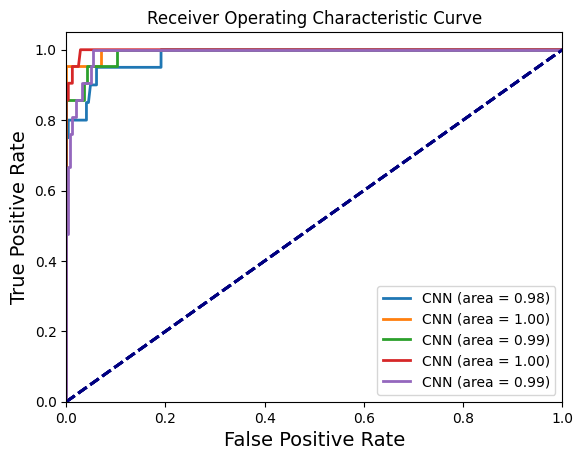

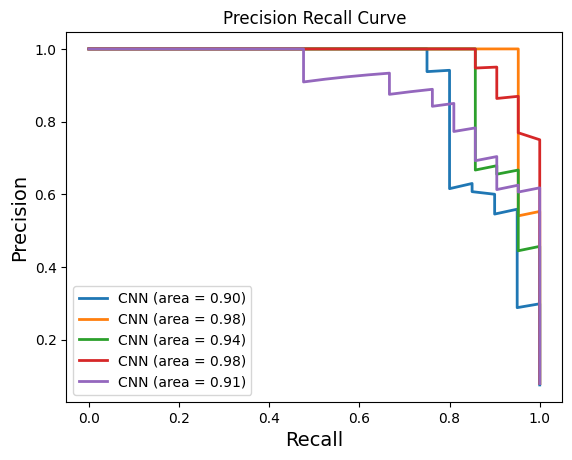

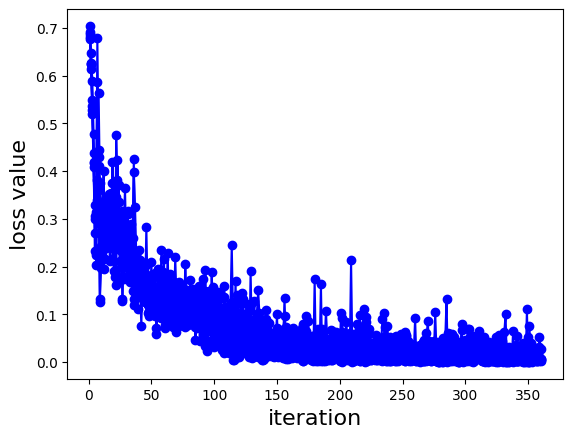

In [59]:
# Perform StratifiedKFold cross-validation to check better the model performances
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE)

accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = [], [], [], [], [], []

# Compute mean and std of each metric and print them
accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = cross_validation(X, y, kfold)

print_performances(accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies)

#### Hyper-parameters Tuning
Perform Hyper-parameters tuning on the best model (DeepPurpose with CNN drug encoding)

In [84]:
# Evaluate the model
def evaluate_model_deep(X_train, y_train, X_val, y_val, X_test, y_test, num_iterations=5, drug_encoding='CNN', mlp_hidden_dims_drug=[32, 16, 8], train_epoch=20, LR=0.001, batch_size=32):
    drug_encoding = 'CNN'
    accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = [], [], [], [], [], []
    for i in range(num_iterations):
        # Train model on X_train and y_train using DeepPurpose
        model = train_model_crossval(X_train, y_train, X_test, y_test, X_valid, y_valid, drug_encoding=drug_encoding, mlp_hidden_dims_drug=mlp_hidden_dims_drug, train_epoch=train_epoch, LR=LR, batch_size=batch_size)

        X_val = utils.data_process(X_drug=X_val, y=y_val, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)

        # Make predictions on the validation set
        y_pred = model.predict(X_val)

        # Convert continuous targets to binary targets using a threshold of 0.5
        y_pred_binary = (np.array(y_pred) > 0.5).astype(int)
        y_val_binary = y_val

        # Calculate evaluation metrics on binary targets
        accuracies.append(accuracy_score(y_val_binary, y_pred_binary))
        precisions.append(precision_score(y_val_binary, y_pred_binary))
        recalls.append(recall_score(y_val_binary, y_pred_binary))
        f1_scores.append(f1_score(y_val_binary, y_pred_binary))

        # Check if there are at least two unique classes in y_val before calculating ROC AUC
        if len(np.unique(y_val_binary)) >= 2:
            roc_aucs.append(roc_auc_score(y_val_binary, y_pred_binary))
        else:
            roc_aucs.append(np.nan)
        balanced_accuracies.append(balanced_accuracy_score(y_val_binary, y_pred_binary))
    
    return accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies


In [85]:
# Perform StratifiedKFold cross-validation to check better the model performances
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED_VALUE)

accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = [], [], [], [], [], []

# Define the parameter grid for grid search
param_grid = {
    'drug_encoding': ['CNN'],
    'mlp_hidden_dims_drug': [[32, 16, 8], [64, 32, 16], [128, 64, 32]],
    'train_epoch': [40, 60],
    'LR': [0.001, 0.01, 0.1],
    'batch_size': [64, 128]
}

In [88]:
# Perform the grid search
best_metric_value = 0.0
best_parameters = None
best_metrics = None

for params in itertools.product(*param_grid.values()):
    drug_encoding, mlp_hidden_dims_drug, train_epoch, LR, batch_size = params

    # Perform cross-validation
    accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = cross_validation(X, y, kfold, drug_encoding, mlp_hidden_dims_drug, train_epoch, LR, batch_size)

    # Compute mean balanced accuracy
    mean_balanced_accuracy = np.mean(balanced_accuracies)

    # Check if the current metric value is better than the previous best metric value
    if mean_balanced_accuracy > best_metric_value:
        best_metric_value = mean_balanced_accuracy
        best_parameters = params  # Store the current parameter combination
        best_metrics = {
            'Accuracy': np.mean(accuracies),
            'Precision': np.mean(precisions),
            'Recall': np.mean(recalls),
            'F1 Score': np.mean(f1_scores),
            'ROC AUC': np.mean(roc_aucs),
            'Balanced Accuracy': mean_balanced_accuracy
        }

    # Display the metric value
    print(f"Parameter combination: {params}")
    print(f"Mean Balanced Accuracy: {mean_balanced_accuracy}")
    print()

# Print the best parameters
print("\nBest Parameters:")
for param_name, param_value in zip(param_grid.keys(), best_parameters):
    print(f"{param_name}: {param_value}")

# Print the metrics of the best model configuration
print("\nMetrics of the Best Model Configuration:")
table_metrics = []
for metric_name, metric_value in best_metrics.items():
    table_metrics.append([metric_name, metric_value])

print(tabulate(table_metrics, headers=['Metric', 'Value']))

Drug Property Prediction Mode...
in total: 665 drugs
encoding drug...
unique drugs: 665
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 665 drugs
encoding drug...
unique drugs: 665
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 665 drugs
encoding drug...
unique drugs: 665
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68427. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.73718 , AUPRC: 0.15281 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.32475. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.90017 , AUPRC: 0.38813 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.42822. Total time 0.00083 hours
Validation at Epoch 3 , AUROC: 0.94288 , AUPRC:

In [ ]:
# Get X and y for train, test, val splits again
# X_train = X_train_selected
# y_train = train_data[CLINTOX_TARGET]

# X_test = X_test_selected
# y_test = test_data[CLINTOX_TARGET]

# X_valid = X_valid_selected
# y_valid = valid_data[CLINTOX_TARGET]

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69235. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.91577 , AUPRC: 0.37138 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.34261. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.93550 , AUPRC: 0.46441 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.16797. Total time 0.00111 hours
Validation at Epoch 3 , AUROC: 0.95095 , AUPR

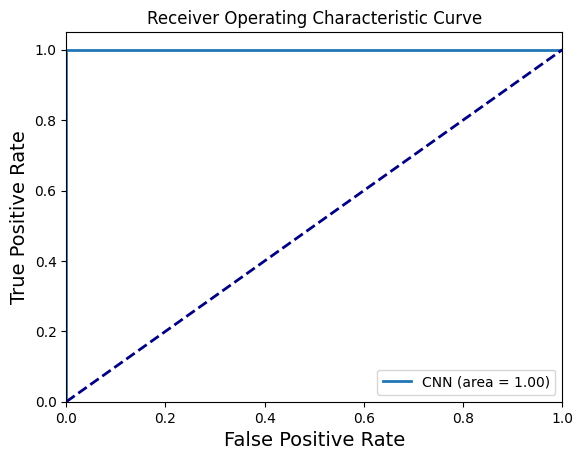

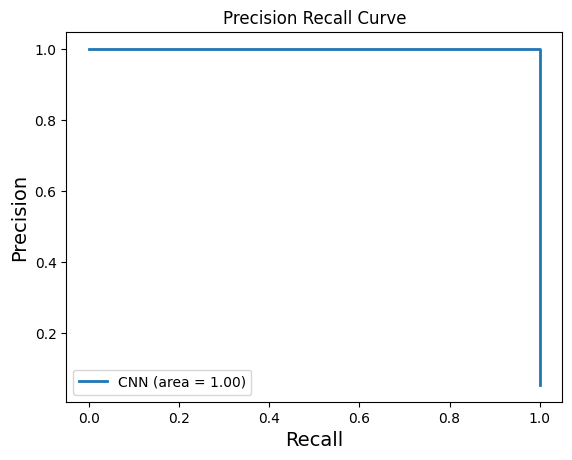

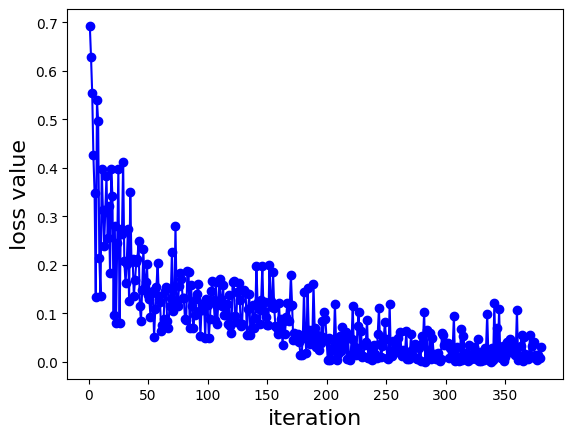

In [ ]:
# Train again the model with the best parameters
drug_encoding, mlp_hidden_dims_drug, train_epoch, LR, batch_size = best_parameters

best_model = train_model_crossval(X_train, y_train, X_test, y_test, X_valid, y_valid, drug_encoding=drug_encoding, mlp_hidden_dims_drug=mlp_hidden_dims_drug, train_epoch=train_epoch, LR=LR, batch_size=batch_size)

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 3 drugs
encoding drug...
unique drugs: 3
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68064. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.93816 , AUPRC: 0.47231 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.12581. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.94509 , AUPRC: 0.55085 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.32972. Total time 0.00138 hours
Validation at Epoch 3 , AUROC: 0.98454 , AUPRC: 0

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

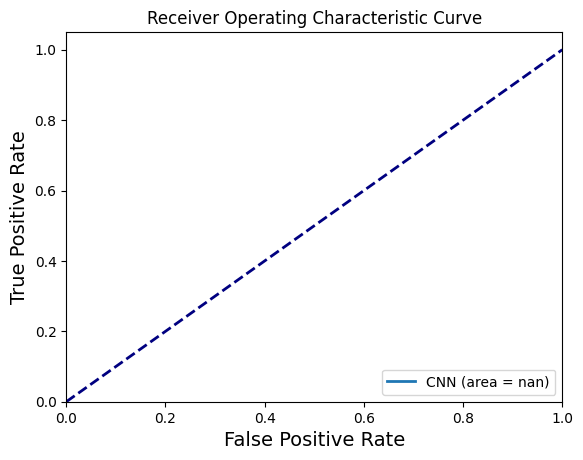

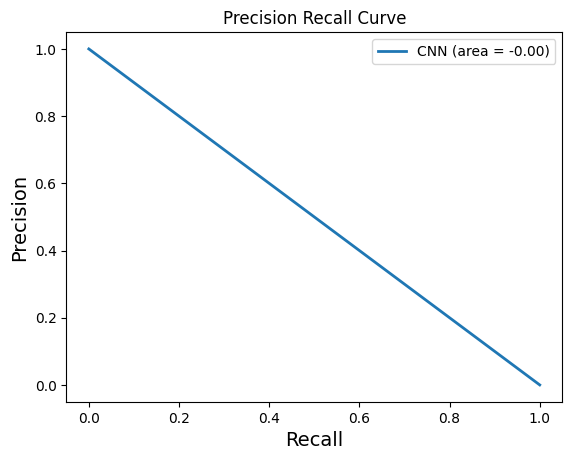

In [ ]:
# Evaluate again the best model on the test set, just to have the metrics mean and standard deviation
accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = evaluate_model_deep(X_train, y_train, X_valid, y_valid, X_test, y_test, drug_encoding=drug_encoding, mlp_hidden_dims_drug=mlp_hidden_dims_drug, train_epoch=train_epoch, LR=LR, batch_size=batch_size)
print_performances(accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies)

#### Explainability

##### Predictions explainability

Counterfactual Explainability

In [63]:
# Get data with the 3 most important features
X_train = X_train_selected
X_test = X_test_selected
X_valid = X_valid_selected
y_train = train_data[CLINTOX_TARGET]
y_test = test_data[CLINTOX_TARGET]
y_valid = valid_data[CLINTOX_TARGET]

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70617. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.84115 , AUPRC: 0.24266 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.27350. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.89978 , AUPRC: 0.35578 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.28611. Total time 0.00111 hours
Validation at Epoch 3 , AUROC: 0.93070 , AUPR

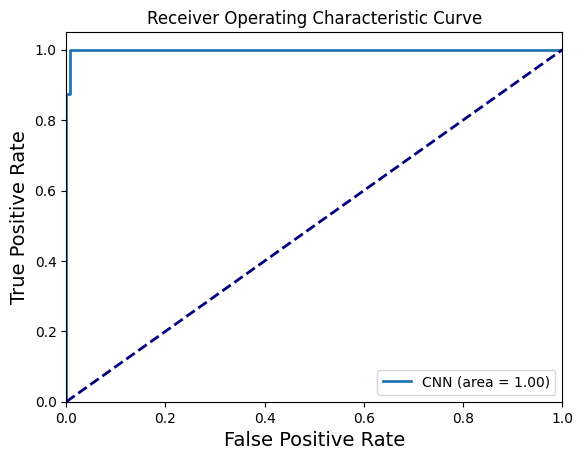

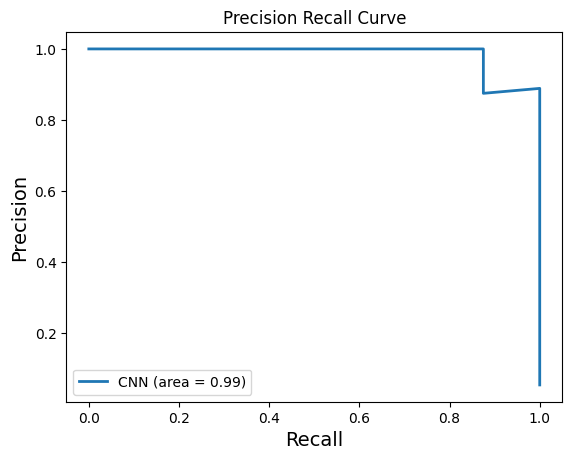

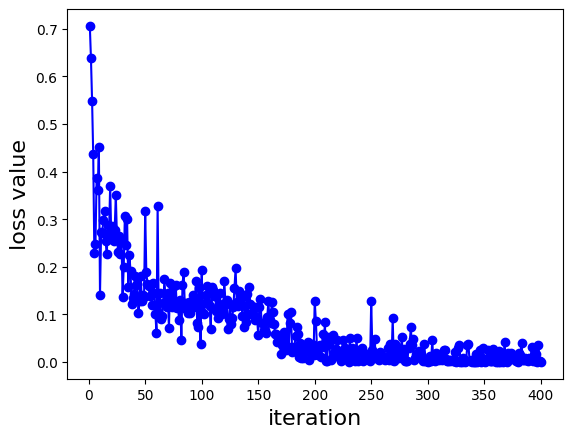

In [64]:
best_model = train_model_crossval(X_train, y_train, X_test, y_test, X_valid, y_valid, drug_encoding, mlp_hidden_dims_drug, train_epoch, LR, batch_size)

In [66]:
# Get a random molecule from the test set and use it for counterfactual analysis
index = random.choice(range(len(X_test)//4))
drug = X_test[index]
label = y_test.values[index]

# Print the randomly sampled drug and label
print("Randomly sampled drug:", drug)
print("Corresponding label:", label)

Randomly sampled drug: Cc1nnc(s1)[N-]S(=O)(=O)c2ccc(cc2)N
Corresponding label: 0


In [67]:
X_test_feats = test_features[selected_feature_names]
X_test_feats =utils.data_process(X_drug=X_test_feats, y=y_test, drug_encoding='CNN', split_method='no_split', random_seed=SEED_VALUE)

Drug Property Prediction Mode...
in total: 4 drugs
encoding drug...
unique drugs: 4
do not do train/test split on the data for already splitted data


In [68]:
# Get model predictions on the test set
# Check if we need to encode the drugs also here
y_pred = best_model.predict(X_test_feats)

# Convert continuous targets to binary targets using a threshold of 0.5
y_pred_binary = (np.array(y_pred) > 0.5).astype(int)

predicting...


In [69]:
# Function to give out a binary output (either 0 or 1) depending on if the score gave by the model.predict value is > 0.5 or not.
y = y_test.to_list()
def predictor(smiles):
    X_drug = [smiles]
    X_pred = utils.data_process(X_drug = X_drug, y = y, drug_encoding = 'CNN', split_method='no_split');
    y_pred = best_model.predict(X_pred)
    answ=1 if y_pred[0]>0.5 else 0
    return answ

In [70]:
# Explain the reasons of the prediction made on nitroxoline using conterfactual explainability

# Generate synthetically feasible molecules from a given SMILES.
space = exmol.sample_space(drug, predictor, batched=False)

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:03<00:00, 943.86it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Predicti

🔭Projecting...🔭:  18%|█▊        | 421.5/2335 [00:00<00:00, 4204.71it/s]            

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
Drug Property Predicti

🤘Done🤘: 100%|██████████| 2335.0/2335 [00:06<00:00, 370.11it/s]          


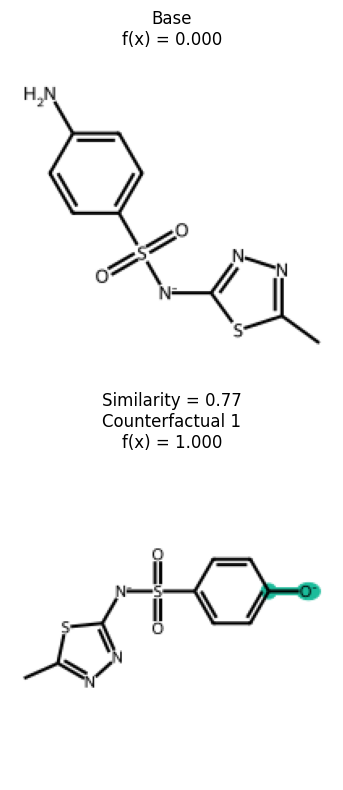

In [71]:
# Check the molecule and a counterfactual graphically
cfs = exmol.cf_explain(space, 1)
exmol.plot_cf(cfs)

# The molecules seem to be similar in structure, but the counterfactual is toxic while the true molecule is not.
# The green higlighted atoms are the ones that made the prediction go towards classifying the molecule as toxic.

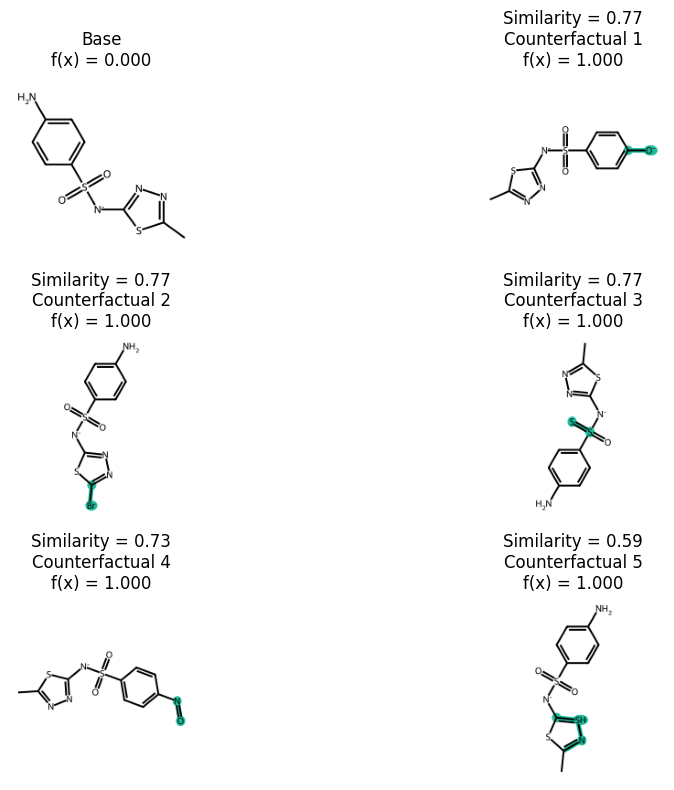

In [72]:
# Look at more than one counterfactuals
cfs = exmol.cf_explain(space, 5)
exmol.plot_cf(cfs)

# The counterfactuals seem to have a similar structure with respect to the Base molecule.
# Again the green highlighted atoms are the ones that made the prediction go towards classifying the molecule as toxic.
# It seems that the atoms bond the outer rings are improtant for the predictions.

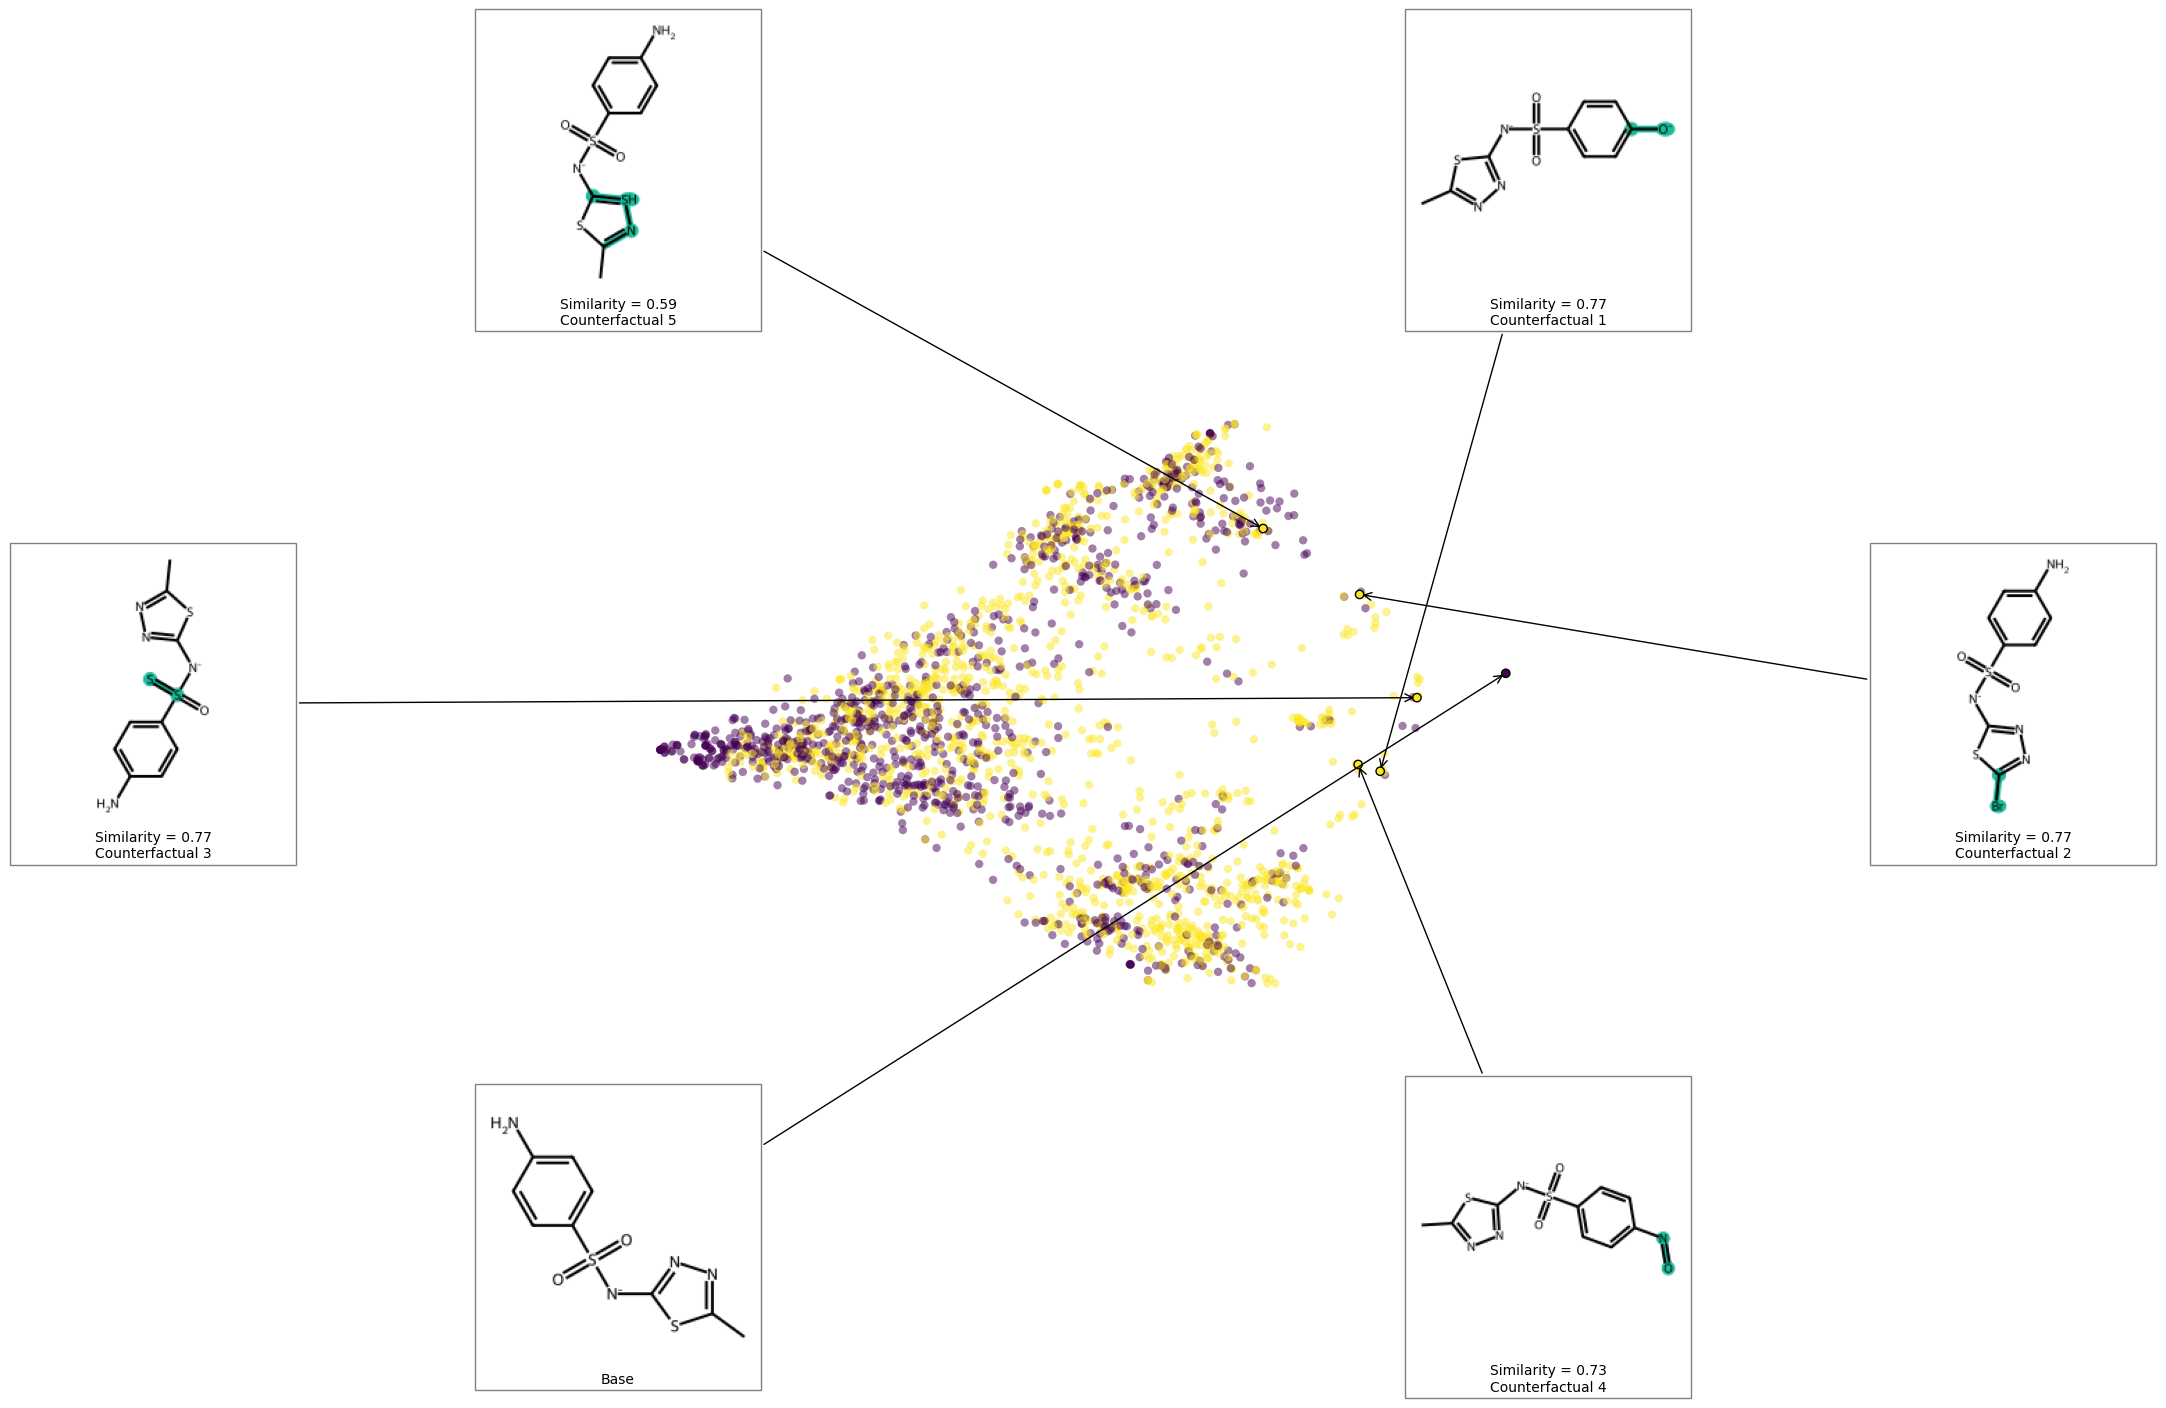

In [73]:
# Plot chemical space around example and annotate given examples (PCA 2 components)
exmol.plot_space(space, cfs)

# From the PCA 2 components representation, the base molecule and counterfactuals are quite near from each other, but the base molecule is outside of the counterfactuals sample space.
# The two classes are overlapped, but the chosen molecule seem to be a bit out of the sample space.

LIME explanation

SMARTS annotations for MACCS descriptors were created using SMARTSviewer (smartsview.zbh.uni-hamburg.de, Copyright: ZBH, Center for Bioinformatics Hamburg) developed by K. Schomburg et. al. (J. Chem. Inf. Model. 2010, 50, 9, 1529–1535)


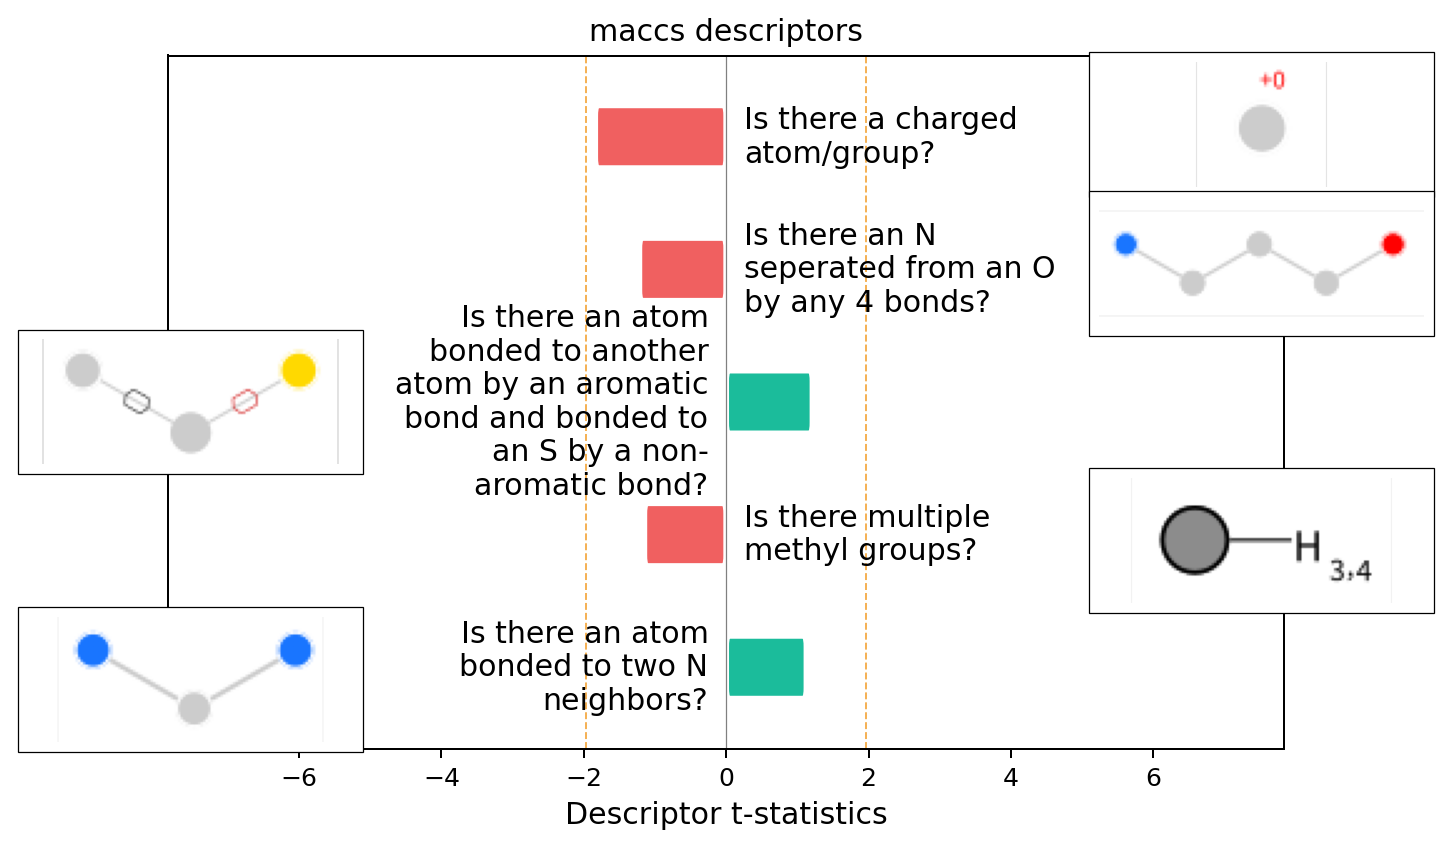

In [74]:
# Explain using substructures 
exmol.lime_explain(space)
exmol.plot_descriptors(space)

# From the substructures explanation, It seems that to have a prediction=1 the most important substructure are:
# - The presence of an atom bonded to another atom by abn aromatic bond and bonded to the S by a non-aromatic bonds.
# - The presence of an atom bonded to two N neighbors.

# The characteristics that are leading to a prediction=0 instead are: 
# - The presence of a charged atom/group.
# - The presence of an N separated from an O by any 4 bonds.
# - The presence of multiple methyl groups.

# Looking at the local explanation above, between the Base molecule and Counterfactuals, the substructures indications doesn't give us information to think they are very different and belong to different classes, 
# but again the one before was just a local explanation of 5 counterfactuals.

In [75]:
exmol.lime_explain(space, descriptor_type="ECFP")
svg = exmol.plot_descriptors(space, return_svg=True)
skunk.display(svg)
svg = exmol.plot_utils.similarity_map_using_tstats(space[0], return_svg=True)
skunk.display(svg)

# From the LIME explanation using ECFP as descriptor type, we see that there is not a single thing that can direct our prediction.
# The rpesence of a hetero S/hetero N nonbasic/aromatic/methyl group or an hetero S/aromatic group could lead to predicting class 1.
# The presence of an aromatic/methyl group, an anion/hetero S/hetero N nonbasic/aromatic grouo or an aromatic atom couls lead to predicting class 0.

# The most important part seem to be the bonds with S N N ring highlighted in red in the image below.
# It is still not easy to determine by the sructure of the molecule if it is going to be classified as 0 or 1.

##### Applicability Domain

In [77]:
# Get again X and y for train, test, val splits
X_train = train_features[features]
y_train = train_features[CLINTOX_TARGET]

X_test = test_features[features]
y_test = test_features[CLINTOX_TARGET]

X_valid = valid_features[features]
y_valid = valid_features[CLINTOX_TARGET]

In [78]:
# Check data distribution in X_train
X_train.describe()

FDA_APPROVED  SmilesLength      MolLogP   ExactMolWt           RB   
count   1182.000000   1182.000000  1182.000000  1182.000000  1182.000000  \
mean       0.933164     58.500000     1.250012   378.636714     5.599831   
std        0.249843     40.541482     3.214980   220.332047     5.595429   
min        0.000000      2.000000   -19.396500    29.997989     0.000000   
25%        1.000000     34.000000    -0.117275   253.863252     2.000000   
50%        1.000000     48.000000     1.615470   332.185635     4.000000   
75%        1.000000     70.000000     3.068350   434.210467     7.000000   
max        1.000000    339.000000    12.605800  1881.070533    53.000000   

       AromaticAtoms   HeavyAtoms           AP  
count    1182.000000  1182.000000  1182.000000  
mean        7.832487    25.859560     0.318918  
std         6.357993    14.837211     0.236463  
min         0.000000     1.000000     0.000000  
25%         0.000000    17.000000     0.000000  
50%         6.000000    23.000000     0.333333  
75%        12.000000    30.000000     0.500000  
max        36.000000   136.000000     0.920000

In [79]:
# Check the distribution of the smiles length in X_train
X_train.smiles.apply(lambda x: len(x)).describe()

count    1182.000000
mean       58.500000
std        40.541482
min         2.000000
25%        34.000000
50%        48.000000
75%        70.000000
max       339.000000
Name: smiles, dtype: float64

In [80]:
# Check data distribution in X_valid
X_valid.describe()

FDA_APPROVED  SmilesLength     MolLogP   ExactMolWt          RB   
count    148.000000    148.000000  148.000000   148.000000  148.000000  \
mean       0.952703     62.216216    1.321796   402.683759    6.006757   
std        0.212995     49.372462    3.008162   262.848579    5.263785   
min        0.000000      8.000000  -12.304600    60.055624    0.000000   
25%        1.000000     31.750000   -0.432600   260.794976    2.000000   
50%        1.000000     48.000000    1.393400   348.114927    5.000000   
75%        1.000000     70.500000    3.315740   470.401596    8.000000   
max        1.000000    316.000000    9.051400  1753.637429   34.000000   

       AromaticAtoms  HeavyAtoms          AP  
count     148.000000  148.000000  148.000000  
mean        8.783784   27.533784    0.320668  
std         8.332822   18.719707    0.237629  
min         0.000000    3.000000    0.000000  
25%         0.000000   18.000000    0.000000  
50%         6.000000   24.000000    0.333333  
75%        12.000000   32.000000    0.500000  
max        60.000000  122.000000    0.882353

In [81]:
# Check the distribution of the smiles length in X_valid
X_valid.smiles.apply(lambda x: len(x)).describe()

count    148.000000
mean      62.216216
std       49.372462
min        8.000000
25%       31.750000
50%       48.000000
75%       70.500000
max      316.000000
Name: smiles, dtype: float64

In [82]:
# Check data distribution in X_test
X_test.describe()

FDA_APPROVED  SmilesLength     MolLogP   ExactMolWt          RB   
count    148.000000    148.000000  148.000000   148.000000  148.000000  \
mean       0.945946     61.195946    1.676695   396.224201    6.229730   
std        0.226892     46.645232    2.750592   262.406608    7.209305   
min        0.000000      3.000000   -6.181000    27.010899    0.000000   
25%        1.000000     34.000000   -0.093175   247.812131    2.000000   
50%        1.000000     48.000000    1.692800   336.158149    5.000000   
75%        1.000000     70.000000    3.469750   443.411573    8.000000   
max        1.000000    253.000000   11.542500  1570.856856   44.000000   

       AromaticAtoms  HeavyAtoms          AP  
count     148.000000  148.000000  148.000000  
mean        8.520270   27.135135    0.323122  
std         6.997054   18.077554    0.224297  
min         0.000000    2.000000    0.000000  
25%         5.000000   17.000000    0.157353  
50%         6.000000   23.000000    0.346832  
75%        12.000000   31.000000    0.487903  
max        30.000000  112.000000    0.857143

In [83]:
# Check the distribution of the smiles length in X_test
X_test.smiles.apply(lambda x: len(x)).describe()

count    148.000000
mean      61.195946
std       46.645232
min        3.000000
25%       34.000000
50%       48.000000
75%       70.000000
max      253.000000
Name: smiles, dtype: float64

The results of the applicability domain analysis are present in the dedicated section of the report. Here we have just the code needed to check some distributions of the data.